# Analyses - Figure 3, S7

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import scanpy.api as sc
import matplotlib as mpl
from matplotlib import rcParams

import seaborn as sns
import scipy as sci

import gseapy as gp
from xlrd import XLRDError
import xlsxwriter

/Users/sophie/miniconda3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()

scanpy==1.0.4+92.g9a754bb.dirty anndata==0.5.10 numpy==1.14.2 scipy==1.0.1 pandas==0.22.0 scikit-learn==0.19.1 statsmodels==0.8.0 python-igraph==0.7.1 louvain==0.6.1 


In [3]:
sc.settings.writedir='./data/'
sc.settings.figdir='./figures/'

In [4]:
sc.set_figure_params(vector_friendly=True, color_map='RdBu_r', dpi_save=300)

In [5]:
adata_all = sc.read('./data/adata_processed.h5')

In [6]:
adata_all_hvg = adata_all[:, adata_all.var.highly_variable].copy()

In [7]:
adata_all_scale = adata_all.copy()
sc.pp.scale(adata_all_scale, max_value=6, zero_center=False)

/Users/sophie/code/scanpy/scanpy/preprocessing/simple.py:1008: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)


In [8]:
sc.pp.pca(adata_all_hvg)

In [9]:
adata_eec = adata_all[adata_all.obs.groups_named_prog4.isin(['EE progenitor', 'EEC'])].copy()

In [10]:
adata_eec_hvg = adata_all_hvg[adata_all_hvg.obs.groups_named_prog4.isin(['EE progenitor', 'EEC'])].copy()

In [11]:
adata_eec_scale = adata_all_scale[adata_all.obs.groups_named_prog4.isin(['EE progenitor', 'EEC'])].copy()

In [12]:
adata_eec_hvg.uns['groups_named_eec_final_colors'] = [
    '#1f77b4', '#aec7e8', '#ffbb78', '#2ca02c', '#d62728',
    '#ff9896', '#c5b0d5', '#8c564b', '#e377c2', '#f7b6d2',
    '#bcbd22', '#c7c7c7', '#9edae5', '#17becf'
]
adata_eec.uns['groups_named_eec_final_colors'] = adata_eec_hvg.uns['groups_named_eec_final_colors']

## EEC manifold

**Note**: Manifold computation depends on python package versions . The manifold may look slightly different when recomputed.

In [14]:
sc.pp.neighbors(adata_eec_hvg, n_neighbors=25, method='gauss')

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:02.22) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix


In [16]:
sc.tl.umap(adata_eec_hvg, min_dist=0.3)

computing UMAP
    finished (0:00:15.08) --> added
    'X_umap', UMAP coordinates (adata.obsm)


In [15]:
adata_eec.obsm['X_umap'] = adata_eec_hvg.obsm['X_umap']

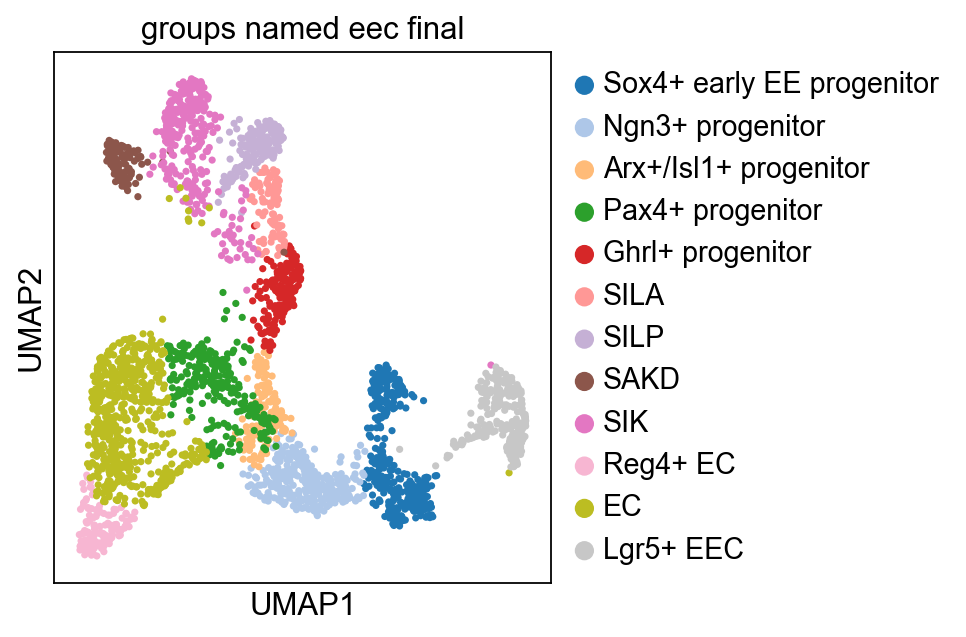

In [16]:
sc.pl.umap(adata_eec_hvg,color=['groups_named_eec_final'])

## EEC marker expression

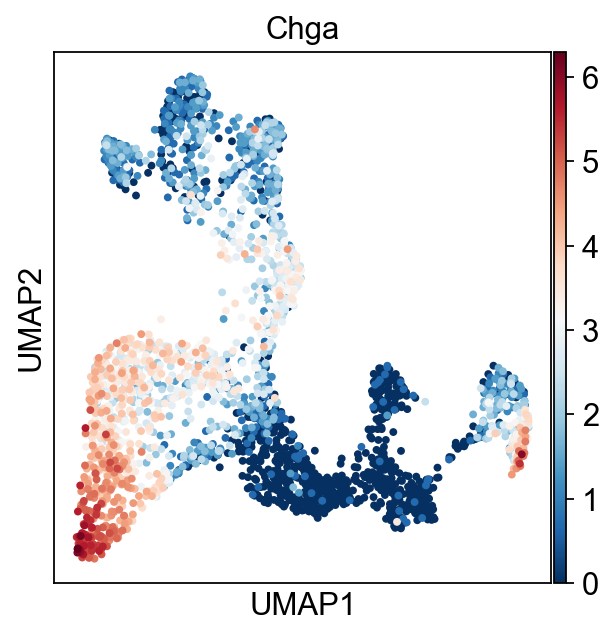

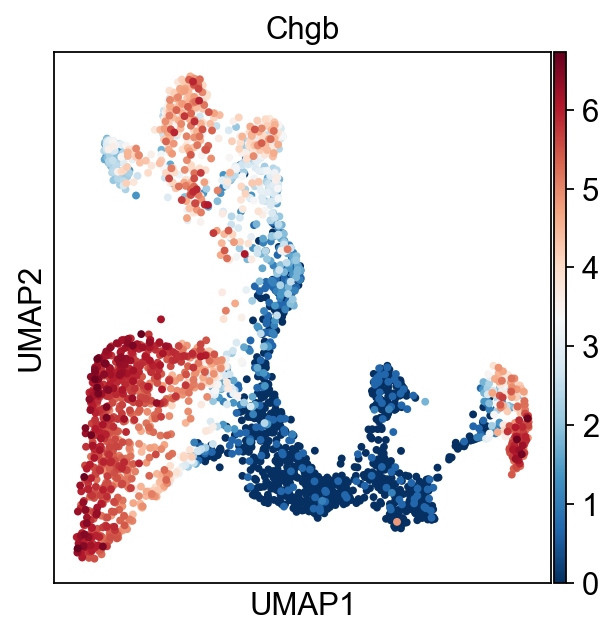

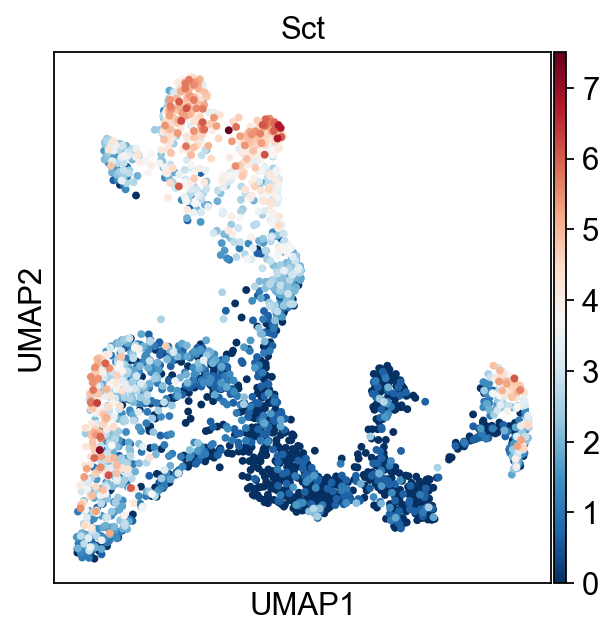

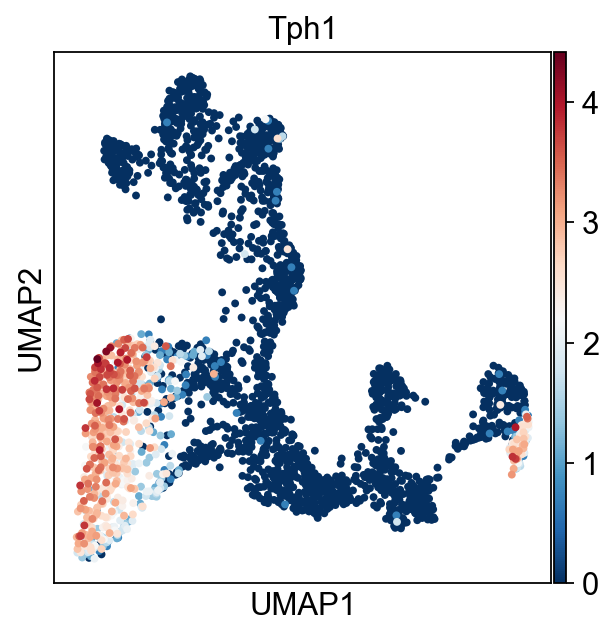

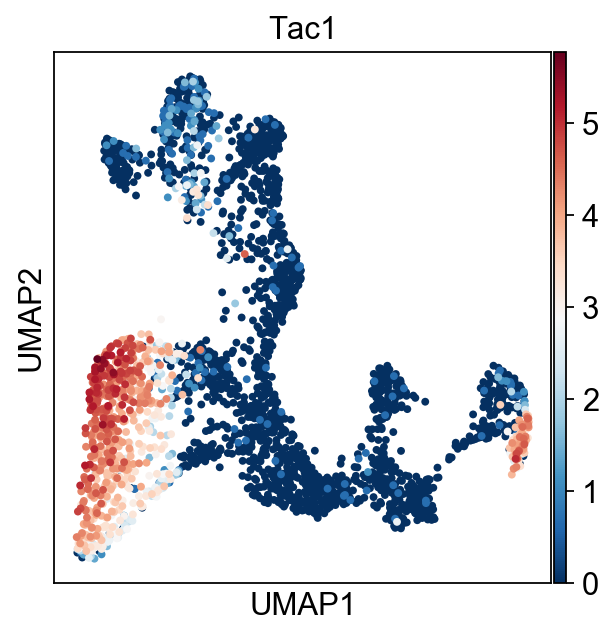

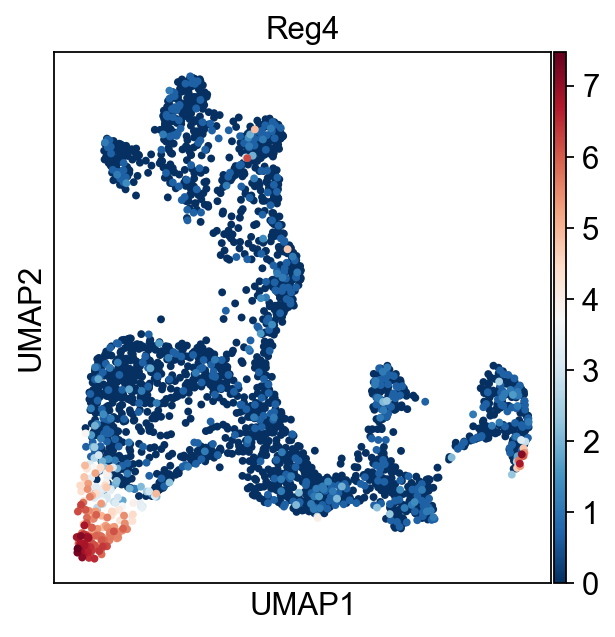

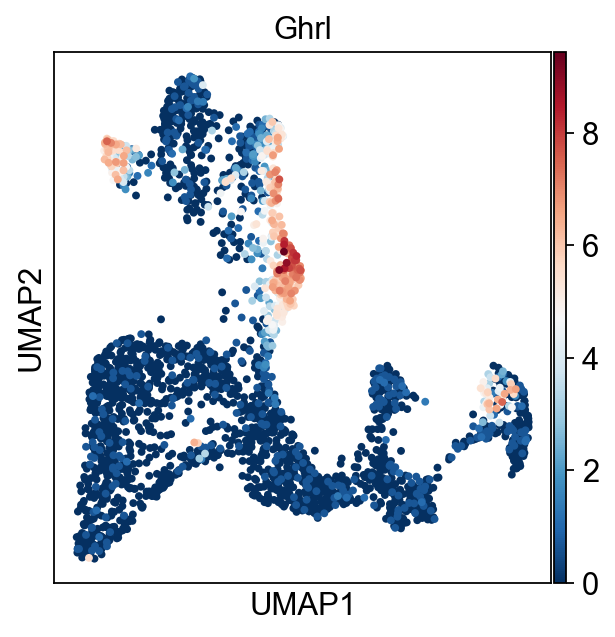

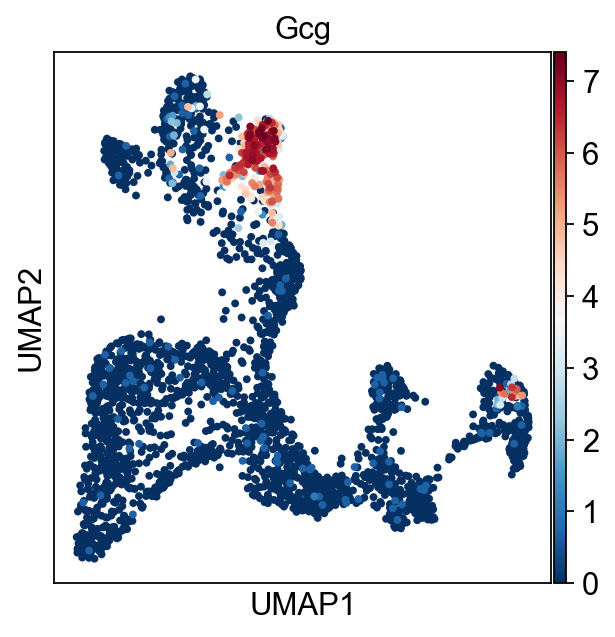

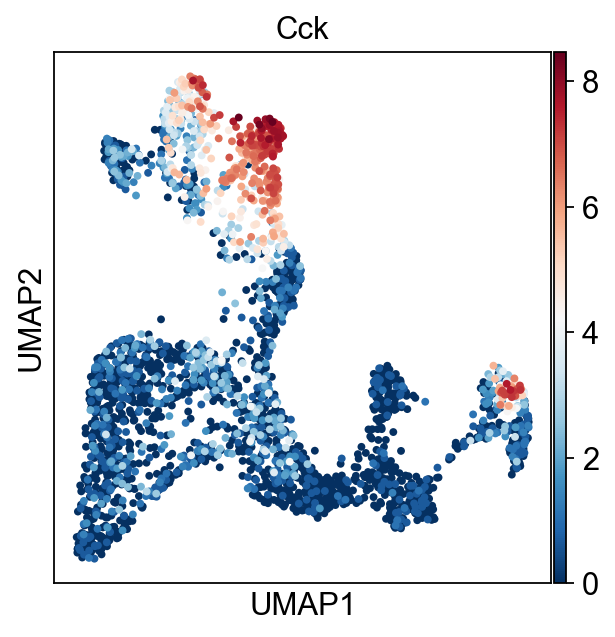

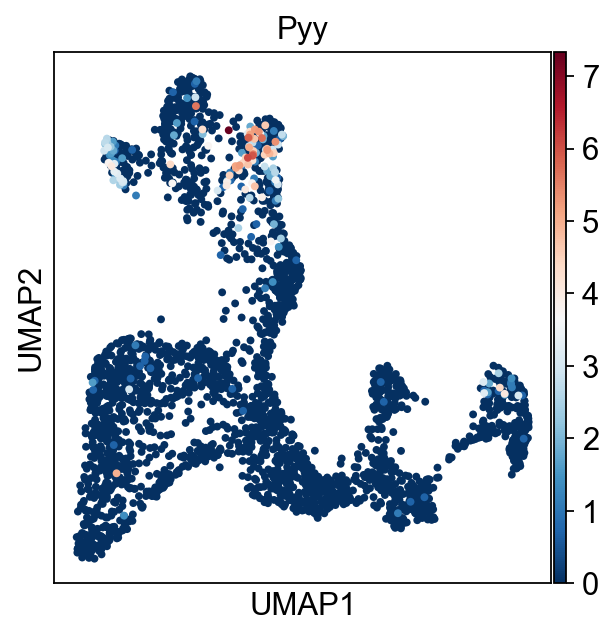

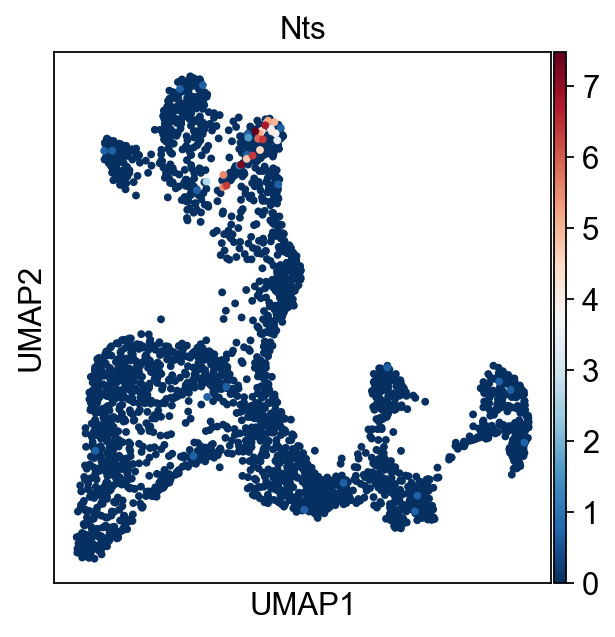

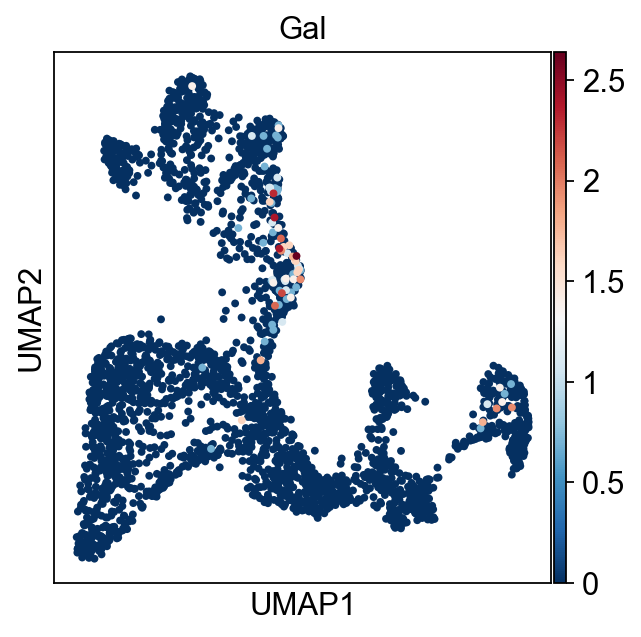

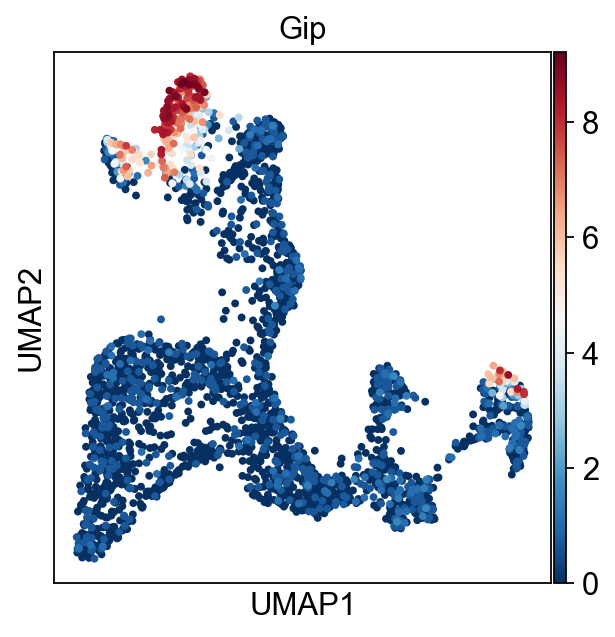

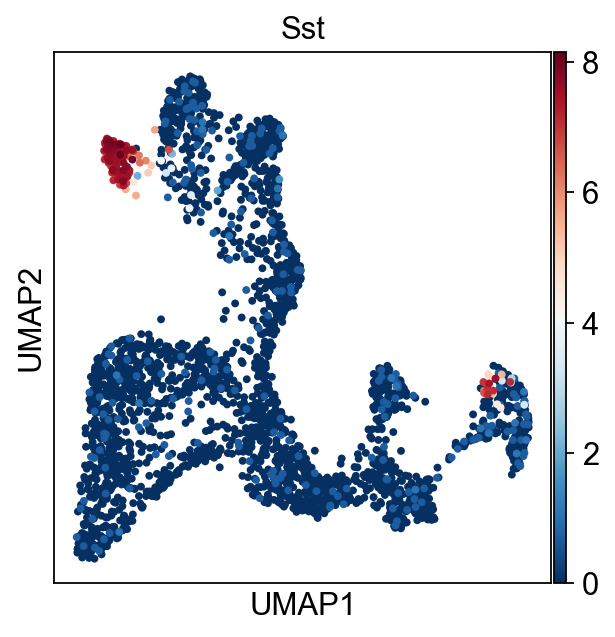

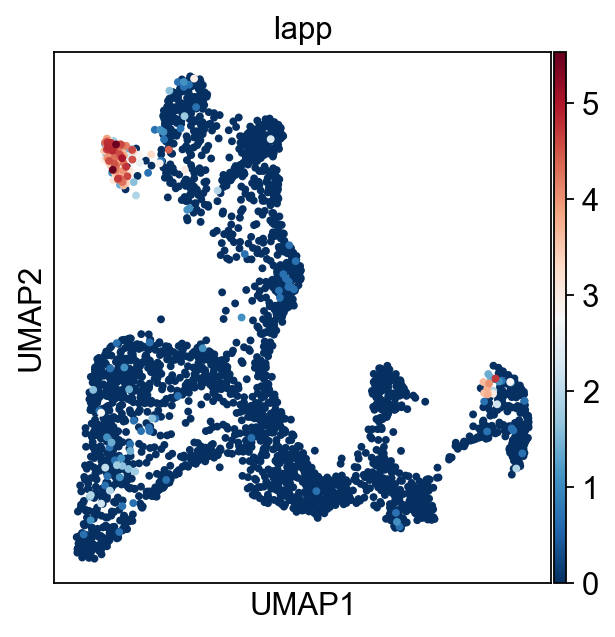

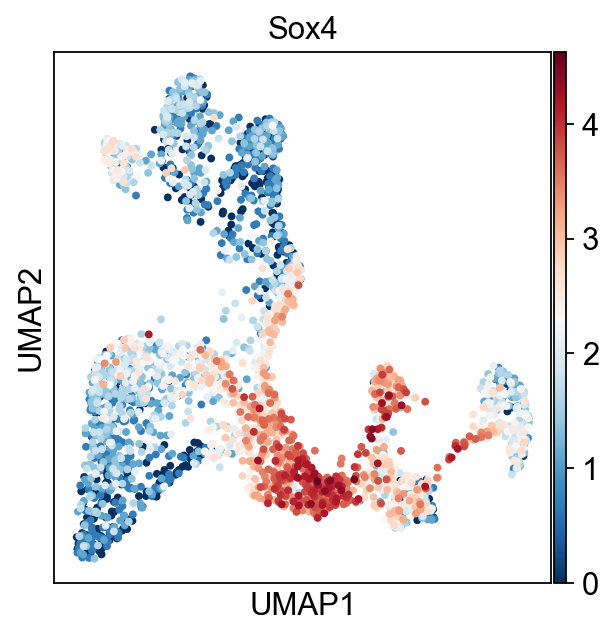

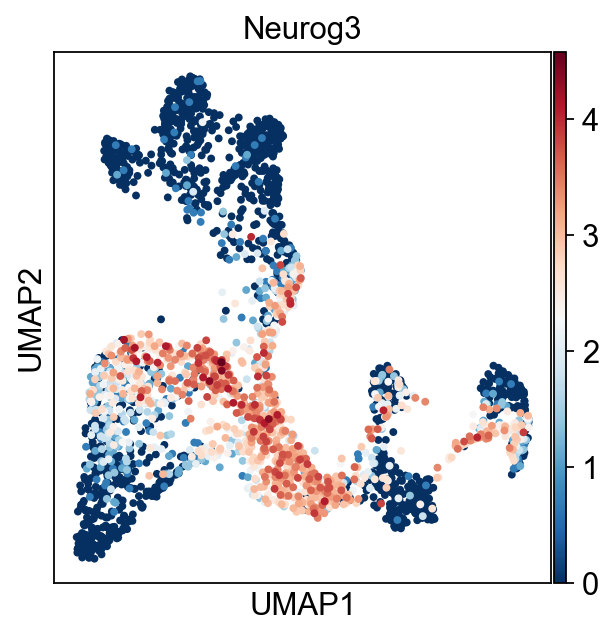

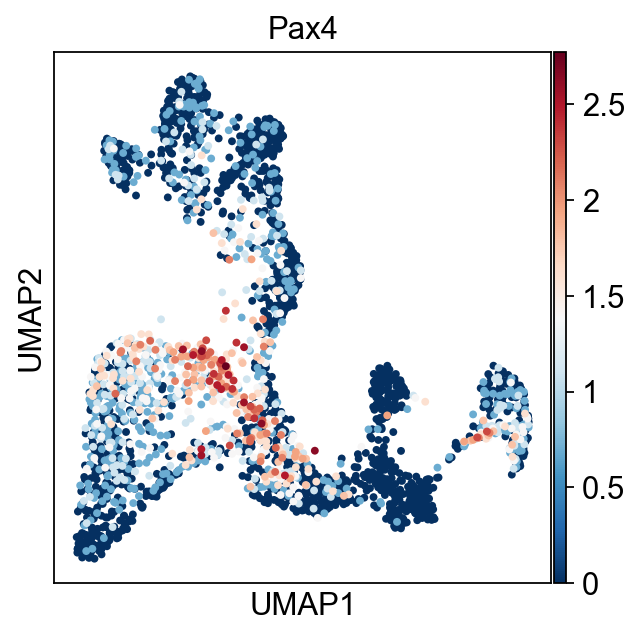

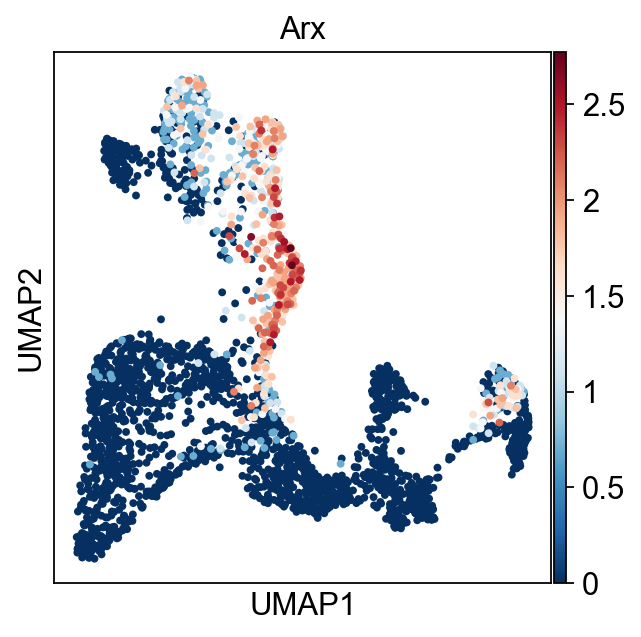

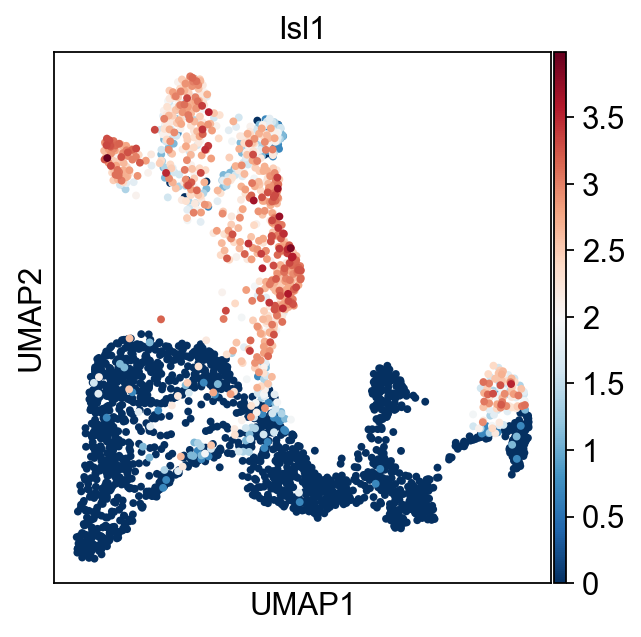

In [17]:
genes = ['Chga', 'Chgb', 'Sct', 'Tph1', 'Tac1', 'Reg4', 'Ghrl', 'Gcg', 'Cck', 'Pyy', 
         'Nts', 'Gal', 'Gip', 'Sst', 'Iapp', 'Sox4', 'Neurog3', 'Pax4', 'Arx', 'Isl1']
for gene in genes:
    sc.pl.umap(adata_eec, color=[gene], color_map='RdBu_r', size=50)

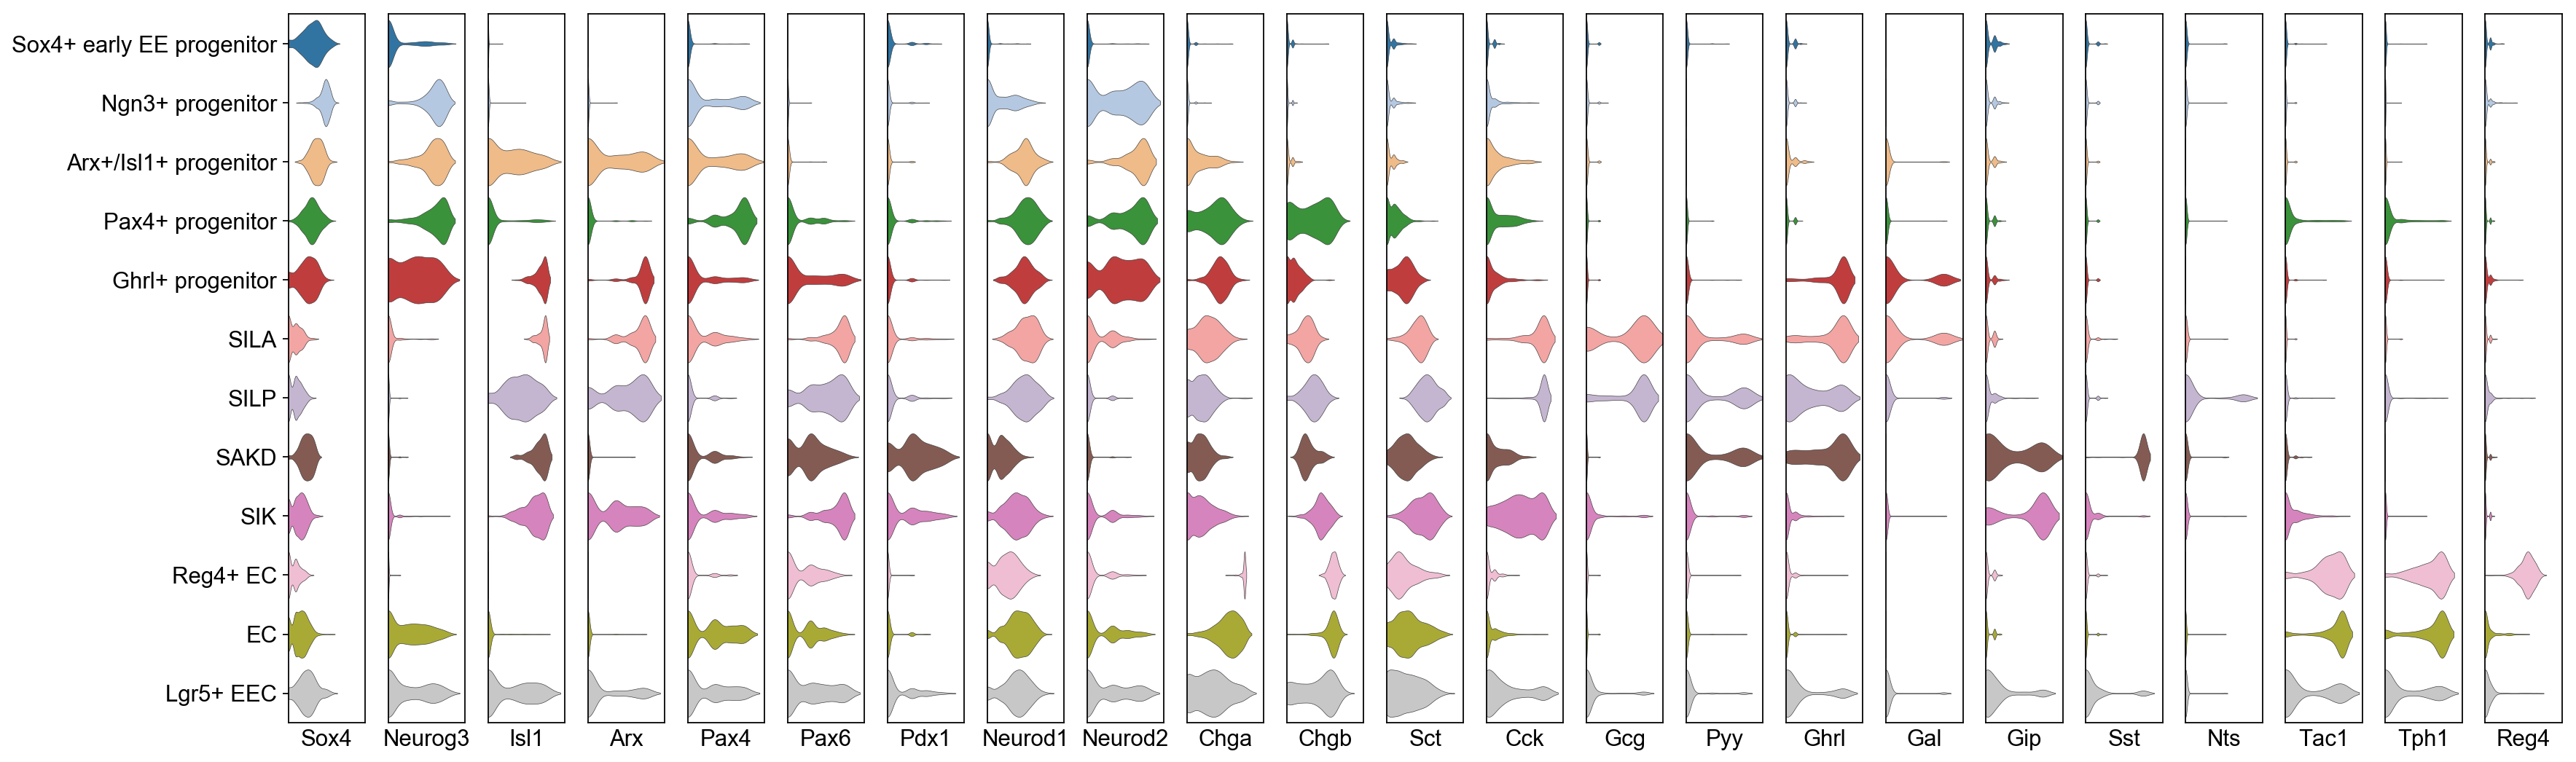

In [18]:
gene_names=['Sox4', 'Neurog3', 'Isl1', 'Arx', 'Pax4', 'Pax6', 
            'Pdx1', 'Neurod1', 'Neurod2', 'Chga', 'Chgb',
            'Sct', 'Cck', 'Gcg', 'Pyy', 'Ghrl', 'Gal', 'Gip', 
            'Sst', 'Nts', 'Tac1', 'Tph1', 'Reg4']


adata_sub=adata_eec_scale.copy()

rcParams['figure.figsize'] = (25, 8)
_, axs = pl.subplots(ncols=len(gene_names), gridspec_kw={'wspace': 0.3})

for i, gene in enumerate(gene_names):
    obs_df = adata_eec_scale.obs
    obs_df[gene] = adata_eec_scale[:, gene].X
    
    sns.violinplot(y='groups_named_eec_final', x=gene, data=obs_df, split=True, scale='width', ax=axs[i], inner=None, linewidth=0.3,
                   palette=adata_eec.uns['groups_named_eec_final_colors'])
    
    if i not in [0]:
        axs[i].set_ylabel('')
        axs[i].get_yaxis().set_ticks([])
    else:
        axs[i].set_ylabel('')
        axs[i].get_yaxis().set_ticks(axs[i].get_yticks())
    axs[i].get_xaxis().set_ticks([])
    axs[i].grid(False)
    axs[i].set_xlim([0,8])
#pl.savefig('./figures/S7_Violin_EEC.pdf', dpi=300, format='pdf')
pl.show()

## EEC lineage relation - PAGA

In [19]:
# subset to CD cells
adata_eec_cd = adata_eec_hvg[adata_eec_hvg.obs['diet'].isin(['CD'])].copy()

# exclude Lgr5+ EEC
adata_eec_cd = adata_eec_cd[np.invert(adata_eec_cd.obs['groups_named_eec_final'].isin(['Lgr5+ EEC']))].copy()

recompute kNN

In [20]:
sc.pp.neighbors(adata_eec_cd, n_neighbors=25, n_pcs=50, method='gauss')

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00.81) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix


get cluster position from umap

exporting label positions to ./data/pos.csv


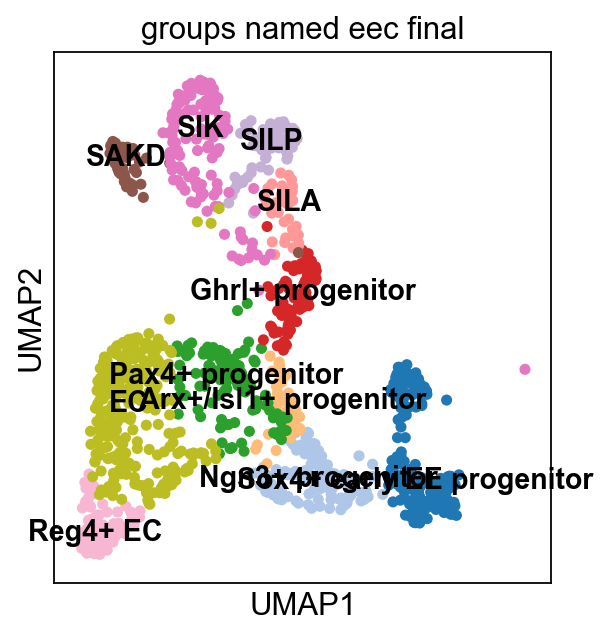

In [21]:
sc.set_figure_params(vector_friendly=True, color_map='RdBu_r', dpi_save=300)
sc.pl.umap(adata_eec_cd, color='groups_named_eec_final', legend_loc='on data export')

In [22]:
pos = np.loadtxt('./data/pos.csv', delimiter=',')

paga

In [23]:
sc.tl.paga(adata_eec_cd,groups='groups_named_eec_final')

running partition-based graph abstraction (PAGA)
    finished (0:00:00.07) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/confidence', confidence adjacency (adata.uns)
    'paga/confidence_tree', confidence subtree (adata.uns)


/Users/sophie/miniconda3/lib/python3.5/site-packages/scipy/sparse/compressed.py:274: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  warn(bad_scalar_msg, SparseEfficiencyWarning)
/Users/sophie/miniconda3/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


--> added 'pos', the PAGA positions (adata.uns['paga'])
saving figure to file ./figures/paga_eec_cd.pdf


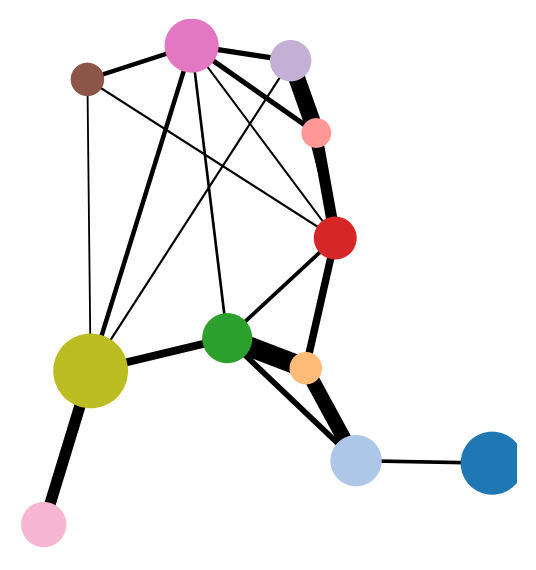

In [24]:
sc.pl.paga(adata_eec_cd, pos=pos, 
           node_size_power=1, threshold_solid=0.01, edge_width_scale=7, node_size_scale=2.5, 
           title='', labels=np.array(['','','','','','','','','','','']), 
           frameon=False, save='_eec_cd')

## Cell type frequencies

### EECs

In [25]:
def bar_frequency_hfd_error_vert(adata, group, celltype1, celltype2, bar_width = 0.4, savefile=None, dpisave=300):
    n_groups = len(adata.obs[group].cat.categories)

    sub_cells = np.isin(adata.obs['diet'], [celltype1])
    print(np.sum(sub_cells))
    adata_filt=adata[sub_cells,:]
    data = adata_filt.obs[[group,'sample']]
    x=data.groupby([group,'sample'])[group].size().unstack().fillna(0)
    tot=x.apply(np.sum)
    x_freq=x/tot
    x_mean=x_freq.apply(np.mean,axis=1)
    x_se=x_freq.apply(np.std,axis=1)/np.sqrt(len(np.unique(adata_filt.obs['sample'])))
    group_names = adata_filt.obs[group].cat.categories

    
    sub_cells = np.isin(adata.obs['diet'], [celltype2])
    print(np.sum(sub_cells))
    adata_filt=adata[sub_cells,:]
    data = adata_filt.obs[[group,'sample']]
    x=data.groupby([group,'sample'])[group].size().unstack().fillna(0)
    tot=x.apply(np.sum)
    x_freq_2=x/tot
    x2_mean=x_freq_2.apply(np.mean,axis=1)
    x2_se=x_freq_2.apply(np.std,axis=1)/np.sqrt(len(np.unique(adata_filt.obs['sample'])))
    
    fig, ax = pl.subplots()
    
    L = np.array(range(n_groups))
    
    index = L[::-1] 
    print(index)
    print(n_groups)
    
    
    opacity = 0.7
    ax.grid(b=None, which='major', axis='x',color='lightgrey')

    rects1 = pl.barh(index+ bar_width, x_mean[group_names]*100, bar_width,
                     alpha=opacity,
                     color='black',xerr=x_se[group_names]*100,
                     error_kw=dict(ecolor='black', lw=1, capsize=3, capthick=1),
                     label='Control')

    rects2 = pl.barh(index, x2_mean[group_names]*100, bar_width,
                     alpha=opacity,
                     color='r',xerr=x2_se[group_names]*100,
                     error_kw=dict(ecolor='black', lw=1, capsize=3, capthick=1),
                     label='HFD')
    
    ax.scatter(x_freq.iloc[:,0]*100, index+ bar_width, color='black', s=10)
    ax.scatter(x_freq.iloc[:,1]*100, index+ bar_width, color='black', s=10)
    ax.scatter(x_freq.iloc[:,2]*100, index+ bar_width, color='black', s=10)
    
    ax.scatter(x_freq_2.iloc[:,0]*100, index, color='black', s=10)
    ax.scatter(x_freq_2.iloc[:,1]*100, index, color='black', s=10)
    ax.scatter(x_freq_2.iloc[:,2]*100, index, color='black', s=10)
    
    ax.set_axisbelow(True)
    
    ax = pl.gca()
    ax.legend_ = None

    pl.ylabel('')
    pl.xlabel('%Cells')

    pl.yticks(index + bar_width / 2, group_names,fontsize=18)
    #ax.set_xticklabels(ax.xaxis.get_major_ticks(),fontsize=14)
    pl.setp(ax.get_xticklabels(), fontsize=14)
    pl.tight_layout()
    
    
    if savefile is not None:
        pl.savefig(savefile,dpi=dpisave,format='pdf')
        
        
    pl.show()
    
    return x_freq, x_freq_2, x_mean, x_se, x2_mean, x2_se

1348
1517
[11 10  9  8  7  6  5  4  3  2  1  0]
12


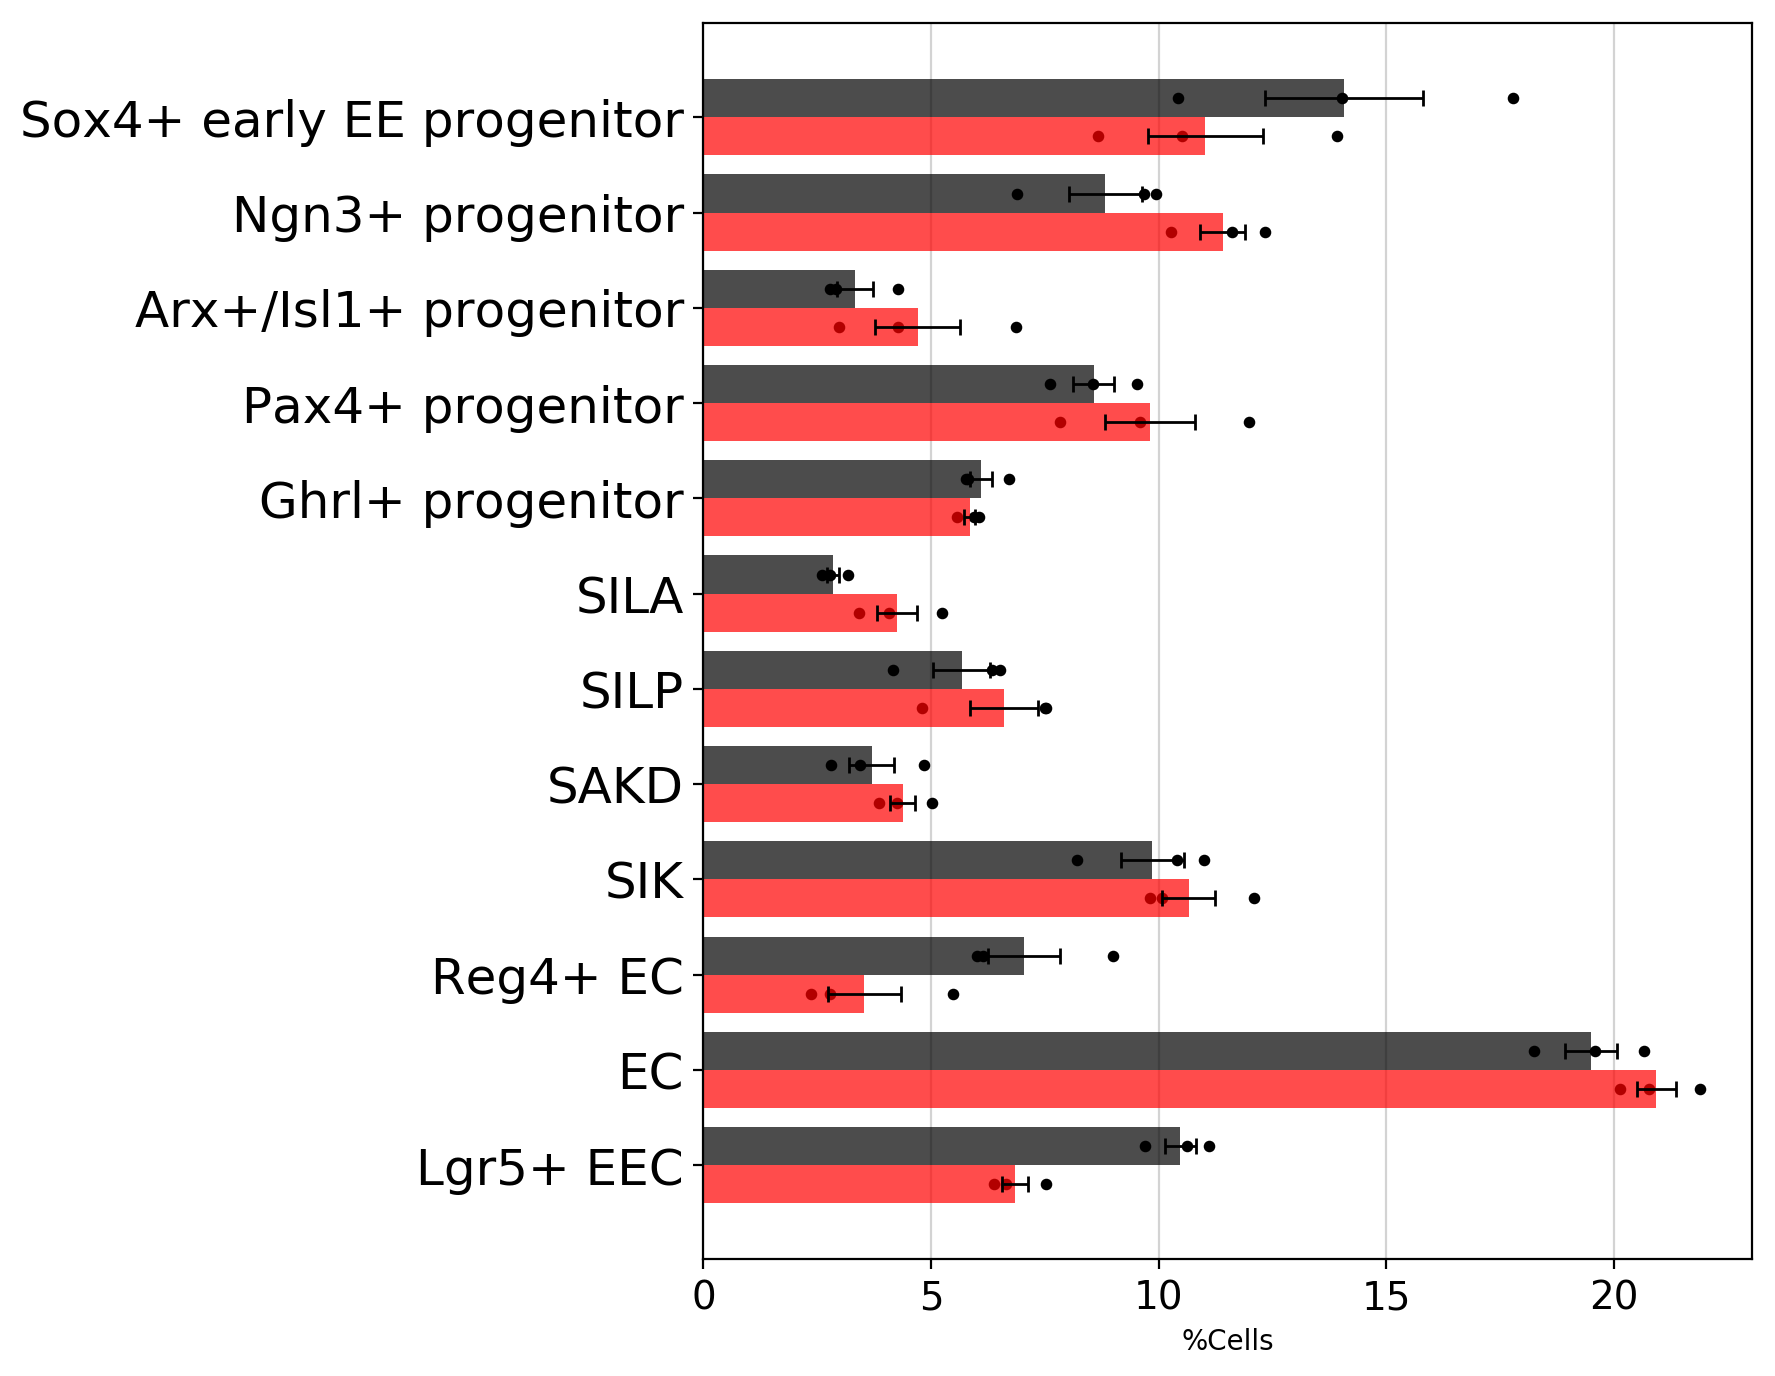

In [26]:
pl.rcParams.update(pl.rcParamsDefault)
rcParams['figure.figsize'] = (9,7)

x_freq, x_freq_2, x_mean, x_se, x2_mean, x2_se = bar_frequency_hfd_error_vert(adata_eec, group='groups_named_eec_final',celltype1='CD',celltype2='HFD',dpisave=300, savefile='figure_3e.pdf')

In [27]:
df = pd.concat([x_freq, x_freq_2, x_mean, x_se, x2_mean, x2_se], axis=1, ignore_index=True)

In [28]:
x_freq.columns.tolist() + x_freq_2.columns.tolist()

['CD_1', 'CD_2', 'CD_3', 'HFD_1', 'HFD_2', 'HFD_3']

In [29]:
df.columns = ['CD_1', 'CD_2', 'CD_3', 'HFD_1', 'HFD_2', 'HFD_3', 'CD_mean', 'CD_sem', 'HFD_mean', 'HFD_sem']

In [30]:
import xlsxwriter
writer = pd.ExcelWriter('./barplots_source_3e.xlsx', engine='xlsxwriter')
df.to_excel(writer)
writer.save()

## EEC marker genes

For the characterization of endocrine subtypes and lineage formation we performed  
i) for each subpopulations pairwise tests against all other subpopulations (including other lineages but excluding the Lgr5+-EEC
population due to the expression of many endocrine subtype markers in this cluster) and defined as specific markers all genes with a score > 5 within top 1200 ranking genes in every test, and   
ii) for the identification of lineage markers pairwise tests against all other subpopulations except mature endocrine subtypes and progenitor subtypes of a later stage and defined as lineage genes all genes with a score > 5 within top 1200 ranking genes in every test. With the former approach we identify genes characteristic for one subtype/stage (transient genes) while with the latter we describe genes that are specifically turned on in a lineage and then potentially sustained.

### specific marker genes

In [39]:
%%time
writer = pd.ExcelWriter('./Supplementary Table 2.xlsx', engine='xlsxwriter')


for catref in ['ISC', 'Enterocyte progenitor', 'Enterocyte', 'Goblet progenitor', 'Goblet cell', 
               'Tuft progenitor', 'Tuft cell', 'Paneth progenitor', 'Paneth cell', 'not annotated', 
               'Sox4+ early EE progenitor', 'Ngn3+ progenitor', 'Arx+/Isl1+ progenitor', 'Pax4+ progenitor', 
               'Ghrl+ progenitor', 'SILA', 'SILP', 'SAKD', 'SIK', 'Reg4+ EC', 'EC']: 
    
    
    for i,cattest in enumerate(np.array(adata_all.obs['groups_named_eec_final'].cat.categories.difference(set([catref,'Lgr5+ EEC'])))):
    
        sc.tl.rank_genes_groups(adata_all, groupby='groups_named_eec_final', n_genes=1200, reference=cattest, groups=[catref], method='wilcoxon')
            
        ix_score=adata_all.uns['rank_genes_groups']['scores'][catref]>5
        genes_top=adata_all.uns['rank_genes_groups']['names'][catref][ix_score]
        scores_top=adata_all.uns['rank_genes_groups']['scores'][catref][ix_score]
    
        if i==0:
            genes = genes_top
        
        else:
            genes = set(genes).intersection(set(genes_top))

    try:

        print(catref)
        df_all=pd.DataFrame(list(genes),columns=['gene'])

        if len(catref)>25:
            i_short=catref[0:25]
            i_short=i_short.replace('/', '_')
            df_all.to_excel(writer,sheet_name=i_short)

        else:
            catref=catref.replace('/', '_')
            df_all.to_excel(writer,sheet_name=catref)
    
    except ValueError:
        print ('no significant marker genes..')
        pass
    

writer.save()

ranking genes
    finished (0:00:06.26) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
ranking genes
    finished (0:00:06.76) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
ranking genes
    finished (0:00:09.87) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
ranking genes
    finished (0:00:25.91) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
ranking genes
    finished (0:00:05.45) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids


### progenitor lineage markers

In [31]:
def get_lineage_markers(adata, obs_name, group, references, thr=6):
    genes_all = []
    for i, ref_cat in enumerate(references):
        adata_sub = adata[adata.obs[obs_name].isin([group, ref_cat])].copy()
        sc.tl.rank_genes_groups(adata_sub, groupby=obs_name, n_genes=1200, method='wilcoxon', groups=[group], reference=ref_cat)
        ix_score = adata_sub.uns['rank_genes_groups']['scores'][group]>thr

        try:
            genes=(list(adata_sub.uns['rank_genes_groups']['names'][group][ix_score]))
            if len(genes_all)==0:
                genes_all = genes
            else:
                genes_all = set(genes_all).intersection(genes)
            
        except ValueError:
            print ('no significant marker genes..')
            pass
    return(list(genes_all))

In [32]:
def save_lineage_markers(genes, group, writer):

    df = pd.DataFrame(genes, columns=['gene'])

    if len(group)>25:
        group_short = group[0:25]
        group_short = group_short.replace('/', '_')
        df.to_excel(writer, sheet_name=group_short)
    else:
        group = group.replace('/', '_')
        df.to_excel(writer, sheet_name=group)

In [33]:
writer = pd.ExcelWriter('./Supplementary Table 3.xlsx', engine='xlsxwriter')

Sox4 progenitor

In [34]:
group='Sox4+ early EE progenitor'
genes_sox4_lin = get_lineage_markers(adata_all, 
                                     obs_name='groups_named_eec_final', 
                                     group=group,
                                     references=['ISC', 'Paneth progenitor', 'Goblet progenitor', 'Tuft progenitor', 'Enterocyte progenitor', 
                                                 'Paneth cell', 'Goblet cell', 'Tuft cell', 'Enterocyte'])

save_lineage_markers(genes_sox4_lin, group, writer)

ranking genes
    finished (0:00:04.89) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
ranking genes
    finished (0:00:00.56) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
ranking genes
    finished (0:00:02.79) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
ranking genes
    finished (0:00:01.21) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
ranking genes
    finished (0:00:14.49) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids


Ngn3 progenitor

In [35]:
group='Ngn3+ progenitor'
genes_ngn3_lin = get_lineage_markers(adata_all, 
                                     obs_name='groups_named_eec_final', 
                                     group=group,
                                     references=['Sox4+ early EE progenitor', 'ISC', 'Paneth progenitor', 'Goblet progenitor', 'Tuft progenitor', 'Enterocyte progenitor', 
                                                 'Paneth cell', 'Goblet cell', 'Tuft cell', 'Enterocyte'])
save_lineage_markers(genes_ngn3_lin, group, writer)

ranking genes
    finished (0:00:00.85) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
ranking genes
    finished (0:00:04.60) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
ranking genes
    finished (0:00:00.46) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
ranking genes
    finished (0:00:02.69) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
ranking genes
    finished (0:00:01.02) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids


Pax4 progenitor

In [36]:
group = 'Pax4+ progenitor'
genes_pax4_lin = get_lineage_markers(adata_all, 
                                     obs_name='groups_named_eec_final', 
                                     group = group,
                                     references=['Ngn3+ progenitor', 'Arx+/Isl1+ progenitor', 'Ghrl+ progenitor', 
                                                 'ISC', 'Paneth progenitor', 'Goblet progenitor', 'Tuft progenitor', 'Enterocyte progenitor', 
                                                 'Paneth cell', 'Goblet cell', 'Tuft cell', 'Enterocyte'])
save_lineage_markers(genes_pax4_lin, group, writer)

ranking genes
    finished (0:00:00.80) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
ranking genes
    finished (0:00:00.45) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
ranking genes
    finished (0:00:00.58) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
ranking genes
    finished (0:00:04.92) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
ranking genes
    finished (0:00:00.41) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids


Arx/Isl1 progenitor

In [37]:
group='Arx+/Isl1+ progenitor'
genes_arx_lin = get_lineage_markers(adata_all, 
                                     obs_name='groups_named_eec_final', 
                                     group=group,
                                     references=['Ngn3+ progenitor', 'Pax4+ progenitor',
                                                 'ISC', 'Paneth progenitor', 'Goblet progenitor', 'Tuft progenitor', 'Enterocyte progenitor', 
                                                 'Paneth cell', 'Goblet cell', 'Tuft cell', 'Enterocyte'])
save_lineage_markers(genes_arx_lin, group, writer)

ranking genes
    finished (0:00:00.49) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
ranking genes
    finished (0:00:00.45) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
ranking genes
    finished (0:00:04.80) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
ranking genes
    finished (0:00:00.25) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
ranking genes
    finished (0:00:02.35) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids


Ghrl progenitor

In [38]:
group='Ghrl+ progenitor'
genes_ghrl_lin = get_lineage_markers(adata_all, 
                                     obs_name='groups_named_eec_final', 
                                     group=group,
                                     references=['Ngn3+ progenitor', 'Pax4+ progenitor', 'Arx+/Isl1+ progenitor',
                                                 'ISC', 'Paneth progenitor', 'Goblet progenitor', 'Tuft progenitor', 'Enterocyte progenitor', 
                                                 'Paneth cell', 'Goblet cell', 'Tuft cell', 'Enterocyte'])
save_lineage_markers(genes_ghrl_lin, group, writer)

ranking genes
    finished (0:00:00.56) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
ranking genes
    finished (0:00:00.41) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
ranking genes
    finished (0:00:00.62) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
ranking genes
    finished (0:00:04.74) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
ranking genes
    finished (0:00:00.28) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids


In [39]:
writer.save()

### EEC progenitor marker expression - plot




In [40]:
def plot_heatmap(adata, obs_name, cats, genes, filename):

    rcParams['figure.figsize'] = (7, len(genes)*0.125)

    fig, axs = pl.subplots(ncols=len(cats), gridspec_kw={'wspace': 0.1})

    for i,group in enumerate(cats):
        adata_sub = adata_marker_scale[adata_marker_scale.obs[obs_name].isin([group])].copy()
        adata_sub = adata_sub[:, genes].copy()

        obs_df = pd.DataFrame(adata_sub.X.toarray(), columns=adata_sub.var_names)
        df_mean = pd.DataFrame(obs_df.mean().T[genes])

        sns.heatmap(df_mean, cmap='RdBu_r', ax=axs[i], yticklabels=i==0, cbar=False, cbar_ax=None, vmin=0, vmax=5)
        axs[i].set_ylabel('')
        axs[i].set_yticklabels(df_mean.index, fontdict={'verticalalignment': 'center','rotation':0,'fontsize':7})
        axs[i].set_xticklabels([])
        axs[i].set_xticks([])

        del obs_df

    fig.tight_layout(rect=[0, 0, .9, 1])
    pl.savefig('./figures/heatmap_progenitor_markers_lineage_'+filename+'.pdf', dpi=300, format='pdf')
    pl.show()
    pl.rcParams.update(pl.rcParamsDefault)

In [41]:
adata_marker_scale = adata_all.copy()
adata_marker_scale = sc.pp.scale(adata_marker_scale ,max_value=5, copy=True, zero_center=False)

cats=['Sox4+ early EE progenitor', 'Ngn3+ progenitor','Pax4+ progenitor',
      'Arx+/Isl1+ progenitor',  'Ghrl+ progenitor', 'SILA',
      'SILP', 'SAKD', 'SIK', 'Reg4+ EC', 'EC']

obs_name = 'groups_named_eec_final'

/Users/sophie/code/scanpy/scanpy/preprocessing/simple.py:1008: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)


/Users/sophie/miniconda3/lib/python3.5/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


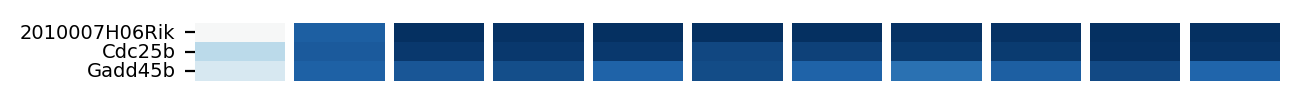

/Users/sophie/miniconda3/lib/python3.5/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


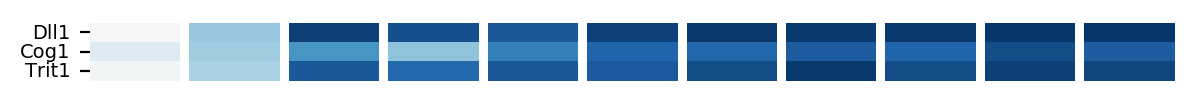

/Users/sophie/miniconda3/lib/python3.5/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


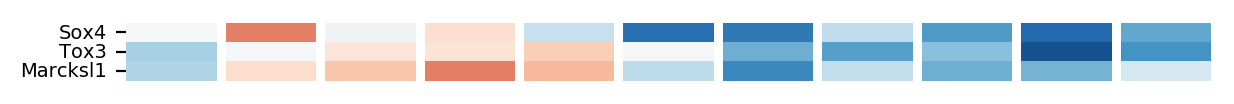

/Users/sophie/miniconda3/lib/python3.5/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


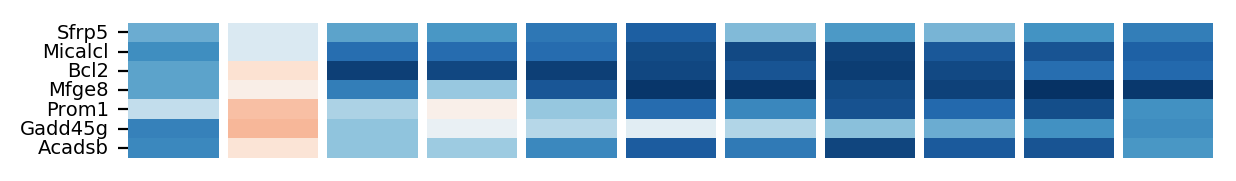

/Users/sophie/miniconda3/lib/python3.5/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


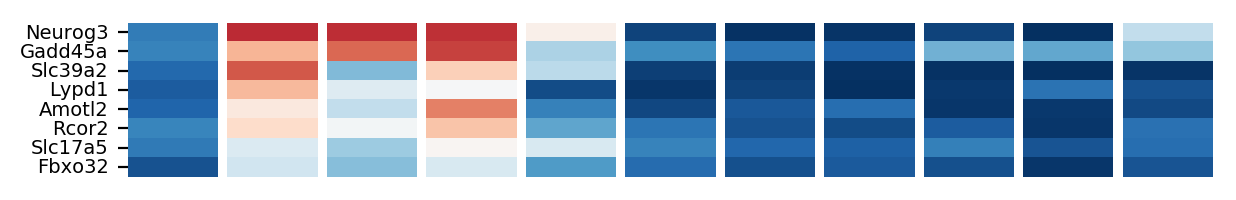

/Users/sophie/miniconda3/lib/python3.5/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


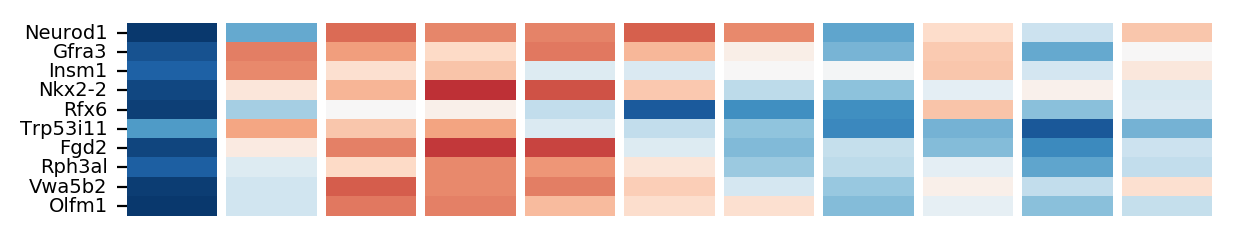

/Users/sophie/miniconda3/lib/python3.5/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


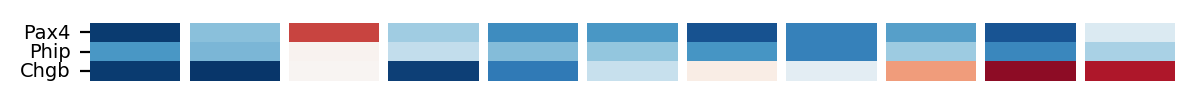

/Users/sophie/miniconda3/lib/python3.5/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


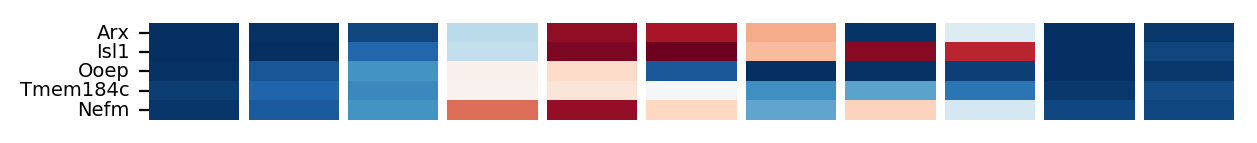

/Users/sophie/miniconda3/lib/python3.5/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


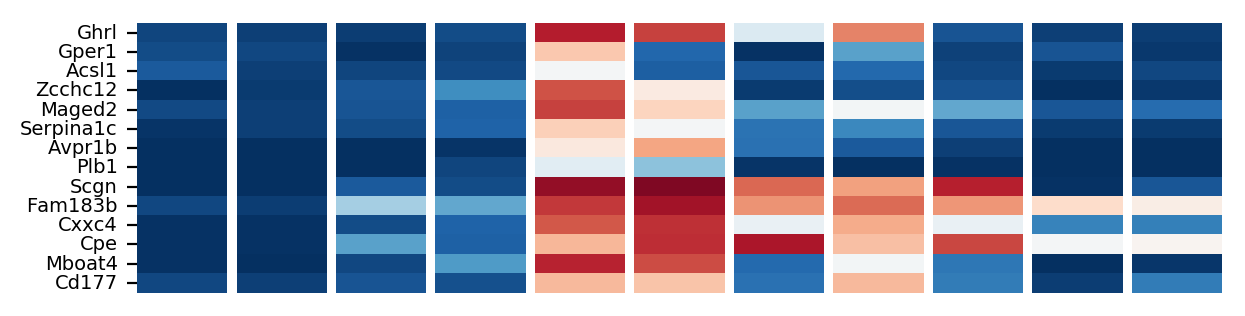

In [42]:
genes=['2010007H06Rik', 'Cdc25b', 'Gadd45b']
plot_heatmap(adata_marker_scale, obs_name, cats, genes, '1')

genes=['Dll1', 'Cog1', 'Trit1']
plot_heatmap(adata_marker_scale, obs_name, cats, genes, '2')

genes=['Sox4', 'Tox3', 'Marcksl1']
plot_heatmap(adata_marker_scale, obs_name, cats, genes, '3')

genes=['Sfrp5', 'Micalcl', 'Bcl2', 'Mfge8', 'Prom1', 'Gadd45g', 'Acadsb']
plot_heatmap(adata_marker_scale, obs_name, cats, genes, '4')

genes=['Neurog3', 'Gadd45a', 'Slc39a2', 'Lypd1', 'Amotl2', 'Rcor2', 'Slc17a5', 'Fbxo32']
plot_heatmap(adata_marker_scale, obs_name, cats, genes, '5')

genes=['Neurod1', 'Gfra3', 'Insm1', 'Nkx2-2', 'Rfx6', 'Trp53i11', 'Fgd2', 'Rph3al', 'Vwa5b2', 'Olfm1']
plot_heatmap(adata_marker_scale, obs_name, cats, genes, '6')

genes=['Pax4', 'Phip', 'Chgb']
plot_heatmap(adata_marker_scale, obs_name, cats, genes, '7')

genes=['Arx','Isl1','Ooep','Tmem184c','Nefm']
plot_heatmap(adata_marker_scale, obs_name, cats, genes, '8')

genes=['Ghrl', 'Gper1', 'Acsl1', 'Zcchc12', 'Maged2', 'Serpina1c', 
       'Avpr1b', 'Plb1', 'Scgn', 'Fam183b', 'Cxxc4', 'Cpe', 'Mboat4', 'Cd177']
plot_heatmap(adata_marker_scale, obs_name, cats, genes, '9')

## EEC mature marker expression - plot

In [43]:
xls = pd.ExcelFile('./Supplementary Table 2.xlsx')

gene_names=[]
for sheet in ['SILA', 'SILP', 'SAKD', 'SIK', 'Reg4+ EC', 'EC']:
    data = pd.read_excel(xls, sheet, index_col=0)
    if data.shape[0] !=0:
        gene_names=list(gene_names)+list(data['gene'].values)[0:25] #top25 markers

/Users/sophie/miniconda3/lib/python3.5/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


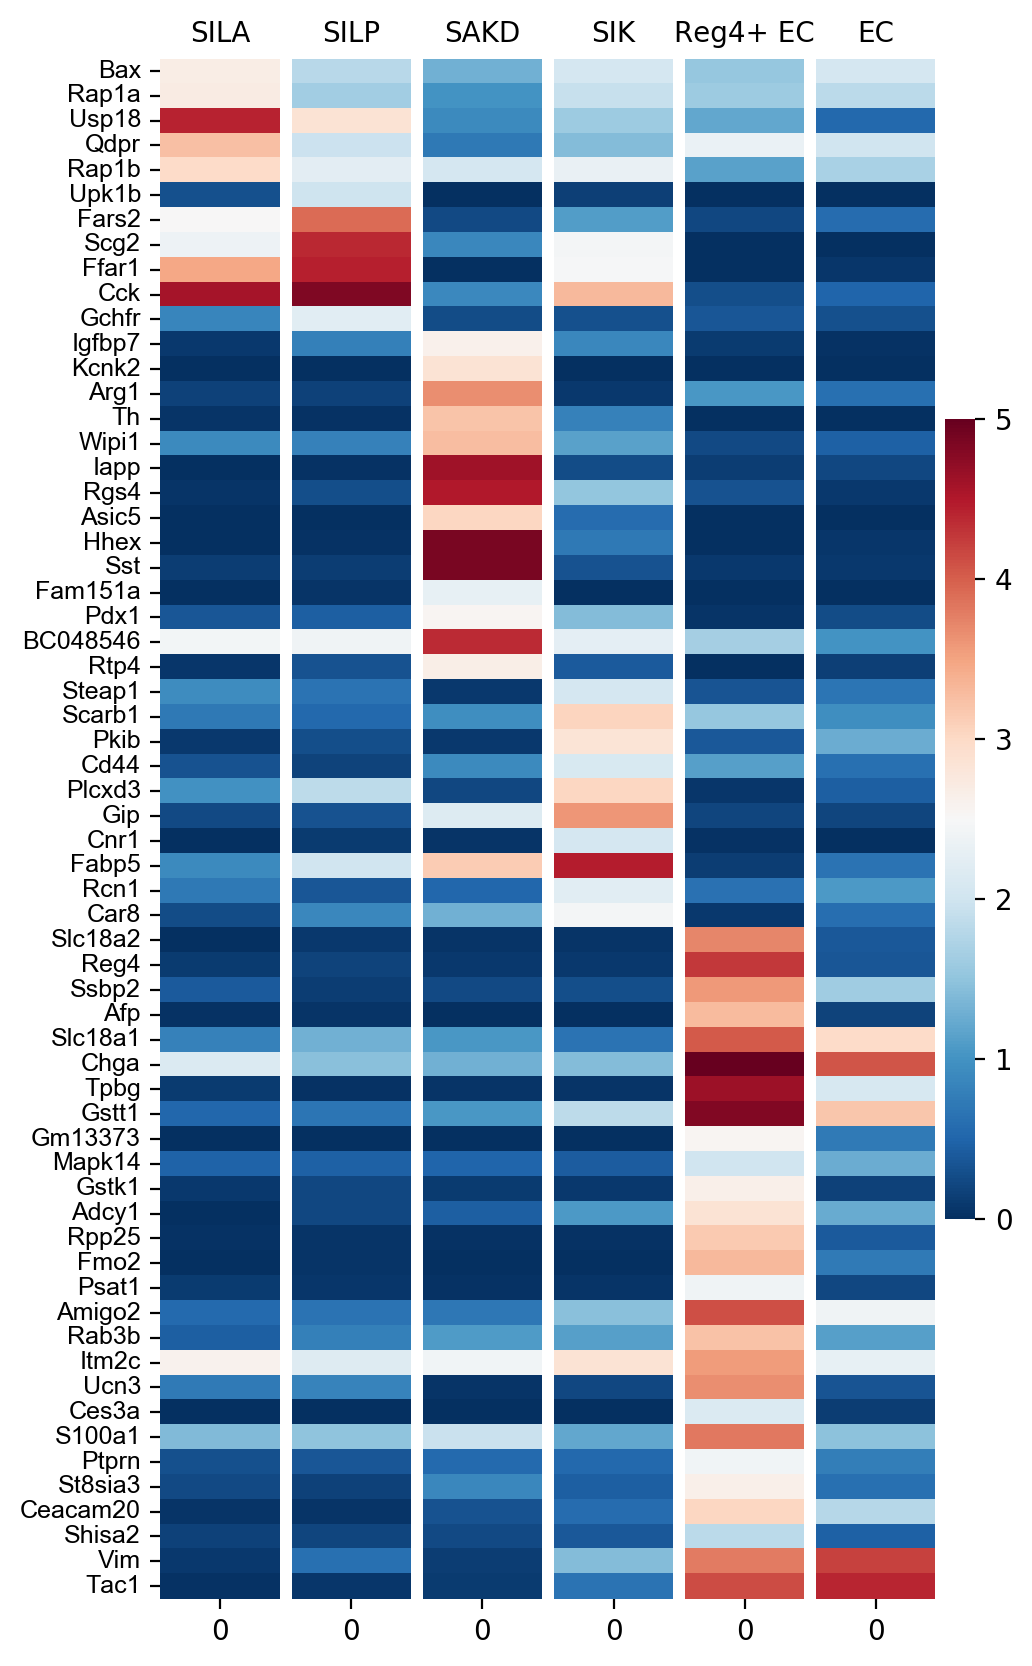

In [44]:
adata_marker_scale = adata_all[:,np.isin(adata_all.var_names, gene_names)].copy()
adata_marker_scale = sc.pp.scale(adata_marker_scale, max_value=5, copy=True, zero_center=False)

rcParams['figure.figsize'] = (5,10)

cats=['SILA','SILP', 'SAKD', 'SIK', 'Reg4+ EC', 'EC']

fig, axs = pl.subplots(ncols=len(cats), gridspec_kw={'wspace': 0.1})
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i,group in enumerate(cats):
    adata_sub =  adata_marker_scale[adata_marker_scale.obs['groups_named_eec_final'].isin([group])].copy()
    
    obs_df = pd.DataFrame(adata_sub.X.toarray(), columns=adata_sub.var_names)
    df_mean = pd.DataFrame(obs_df.mean().T[gene_names])

    sns.heatmap(df_mean, cmap='RdBu_r', ax=axs[i], cbar=i==0, yticklabels=i==0, cbar_ax=None if i else cbar_ax, vmin=0, vmax=5)
    axs[i].set_title(cats[i], fontsize=10)
    axs[i].set_ylabel('')
    axs[i].set_yticklabels(df_mean.index, fontdict={'verticalalignment': 'center','rotation':0,'fontsize':9,'fontname':'Arial'})

    del obs_df
    
fig.tight_layout(rect=[0, 0, .9, 1])
pl.savefig('./figures/Heatmap_endocrine_mature_marker.pdf', dpi=300, format='pdf')
pl.show()
pl.rcParams.update(pl.rcParamsDefault)

## EEC hormone expression

In [45]:
gene_names=['Chga','Chgb', 'Gast', 'Ghrl', 'Cck', 'Gal', 'Pyy', 'Gcg', 
            'Bdnf', 'Scgn', 'Gip', 'Fabp5', 'Sct', 'Tac1', 'Sst', 'Iapp', 
            'Tph1', 'Gch1', 'Reg4', 'Afp', 'Nts']

# subset to mature EEC subtypes and hormones
adata_eec = adata_all[adata_all.obs['groups_named_eec_final'].isin(['SILA', 'SILP', 'SAKD', 'SIK', 'Reg4+ EC', 'EC'])].copy()
adata_eec_sub = adata_eec[:, np.isin(adata_eec.var_names, gene_names)].copy()
obs_df = pd.DataFrame(adata_eec_sub.X.toarray(), columns=adata_eec_sub.var_names)

# set expression <3 to zero
count_thr = np.log1p(3)
obs_df[obs_df<=count_thr] = 0

obs_df['diet'] = adata_eec_sub.obs['diet'].values

x = obs_df.groupby(['diet'])

def meaninncells(x):
    ix=x>0
    mpc=np.mean(x[ix])
    
    return(mpc)

df_mean = x[gene_names].apply(meaninncells).T

In [46]:
pd.crosstab(adata_eec_sub.obs.diet, adata_eec_sub.obs.groups_named_eec_final)

groups_named_eec_final  SILA  SILP  SAKD  SIK  Reg4+ EC   EC
diet                                                        
CD                        38    77    49  135        93  264
HFD                       64   102    66  164        52  319

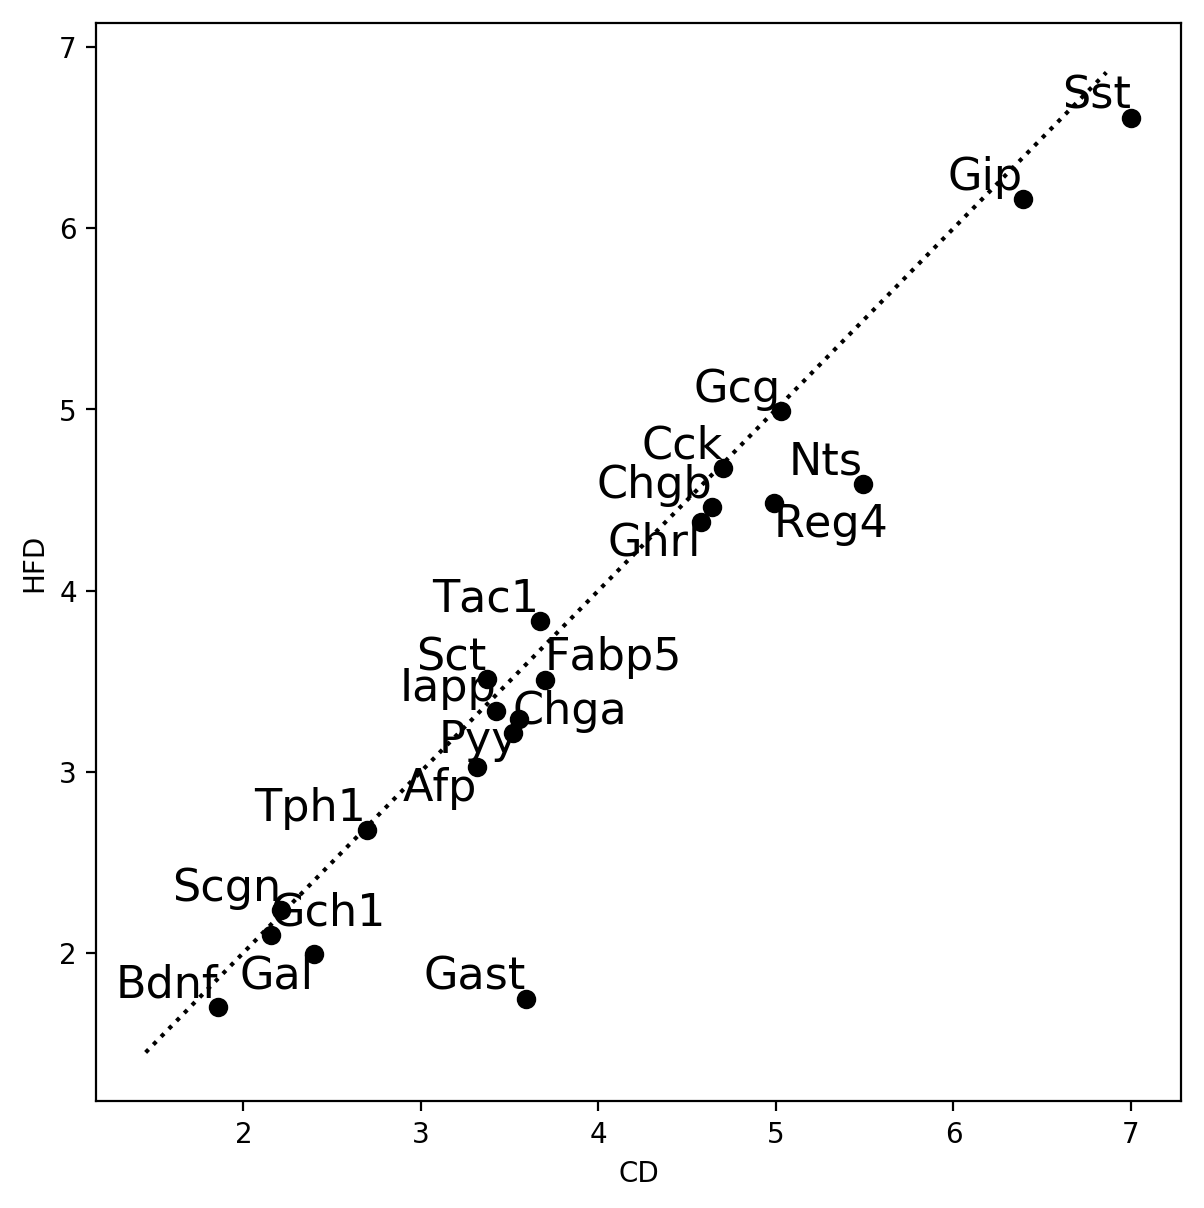

In [47]:
fig, ax = pl.subplots(figsize=(7,7))
ax.scatter(df_mean['CD'], df_mean['HFD'], c='black')
yax = ax.get_ylim()
ax.plot(yax,yax,'k:')

for label, xa, ya in zip(df_mean.index, df_mean['CD'], df_mean['HFD']):
    if (label=='Gch1') | (label=='Chga') | (label=='Fabp5'):
        ax.annotate(label,xy=(xa, ya), xytext=(-0.1, 0.1),textcoords='offset points', ha='left', va='bottom',fontsize=16)#, 
    
    elif (label=='Gal') | (label=='Pyy') | (label=='Afp') | (label=='Ghrl'):
        ax.annotate(label,xy=(xa, ya), xytext=(-0.1, 0.1),textcoords='offset points', ha='right', va='top',fontsize=16)#,   

        
    elif (label=='Reg4'):
        ax.annotate(label,xy=(xa, ya), xytext=(-0.1, 0.1),textcoords='offset points', ha='left', va='top',fontsize=16)#,   

    else:
        ax.annotate(label,xy=(xa, ya), xytext=(-0.1, 0.1),textcoords='offset points', ha='right', va='bottom',fontsize=16)
        
pl.xlabel('CD')
pl.ylabel('HFD')

#pl.savefig('/Users/sophie/Documents/ICB/Projects/2017_10X_HFD/Analysis_new_vers_1_0/final_figures/S4_hormone_expression.pdf',format='pdf',dpi=300)

pl.show()

## Differential expression in EEC subtypes between HFD and CD mice

In [48]:
def plot_volcano_top10(data, x, y, lfcthr, pthr, xax=None, yax=None,
                     data_point_size=50):
       
    fig, ax = pl.subplots()
    if xax is not None:
        ax.set_xlim(xax)
    if yax is not None:
        ax.set_ylim(yax)

    ### upregulated genes
    ix_up=data[x]>0
    data_up=data[ix_up]
    ix_fc=data_up[x]>lfcthr
    ix_p=data_up[y]>pthr
    
    ix_genes=[a and b for a, b in zip(ix_fc,ix_p)] 
    col1=['black' if value else 'grey' for value in ix_genes]   
    
    # plot
    ax.scatter(data=data_up,x=x, y=y,  s=data_point_size,c=col1,rasterized=True,marker='o',alpha=.3) #scatter_kws={'c':DF_0['color']}
    
    ### annotate top 10 genes
    data_up=data_up[ix_genes]
    data_up.sort_values(by=y,inplace=True,ascending=False)
    data_up=data_up[0:10]
    # change marker color and size
    ax.scatter(data=data_up, x=x, y=y, s=data_point_size+10, c='red', rasterized=True, marker='o', alpha=.3)

    ### down regulated genes
    ix_down=data[x]<0
    data_down=data[ix_down]
    ix_fc=data_down[x]< -lfcthr
    ix_p=data_down[y]>pthr
    
    ix_genes=[a and b for a, b in zip(ix_fc,ix_p)] 
    col2=['black' if value else 'grey' for value in ix_genes]
    
    # plot
    ax.scatter(data=data_down,x=x, y=y,  s=data_point_size,c=col2,rasterized=True,marker='o',alpha=.3) #scatter_kws={'c':DF_0['color']}
    ax.axhline(pthr,c='red',linestyle=':',linewidth=1)
    
    ### annotate top 5 genes
    data_down=data_down[ix_genes]
    data_down.sort_values(by=y,inplace=True,ascending=False)
    data_down=data_down[0:5]
    # change marker color and size
    ax.scatter(data=data_down, x=x, y=y, s=data_point_size+10, c='red', rasterized=True, marker='o', alpha=.3)
    
    
    ### add lines add significance thresholds
    yax=ax.get_ylim()
    ax.axvline(lfcthr,c='red',linestyle=':',linewidth=1,ymin=(0-yax[0])/(yax[1]-yax[0]))  ### set start to 0
    ax.axvline(-lfcthr,c='red',linestyle=':',linewidth=1,ymin=(0-yax[0])/(yax[1]-yax[0]))  ### set start to 0
    
    ### add axes labels
    ax.set_xlabel('log2 foldchange',fontdict={'fontsize':16})
    ax.set_ylabel('-log10(q-value)',fontdict={'fontsize':16})
    return(ax,data_up,data_down)

In [49]:
from xlrd import XLRDError
filename = './differential_expression/Supplementary Table 4.xlsx'

In [51]:
x='logFC'
y='log_p'

#### SIK

In [52]:
genes_ambient= [
    'Defa24', 'Gm15284', 'Lyz1', 'Gm14851', 'Itln1', 'Defa17',
    'AY761184', 'Gm14850', 'Defa20', 'Clps', 'Gm7861', 'Spink4',
    'Ang4', 'Defa22', 'Defa26', 'Defa21', 'Gm21002', 'Defa23',
    'Defa-rs1', 'Gm15308', 'Defa3', 'Zg16', 'Agr2', 'Tff3', 'Reg4',
    'Ccl6', 'Defa5', 'Mptx2', 'Fcgbp', 'Tmsb10','Ifitm3', 'H2afv', 
    'Zfos1', 'Smim24', 'Plac8', 'Oat', 'Fth1', 'Aldob'
]
# Fabp2 shows above ambient difference

In [53]:
### prepare data
group = 'SIK'

# transform p-values
df1 = pd.read_excel(filename, sheet_name = group, index_col=0)
df1['log_p'] = np.log10(df1['adj.P.Val'].values)
df1['log_p'][np.isneginf(df1['log_p'])] = min(df1['log_p'][np.invert(np.isneginf(df1['log_p']))])-1
df1['log_p'] = abs(df1['log_p'])

# exclude ambient genes
ix = np.isin(df1.index,genes_ambient)
df1 = df1[np.invert(ix)]

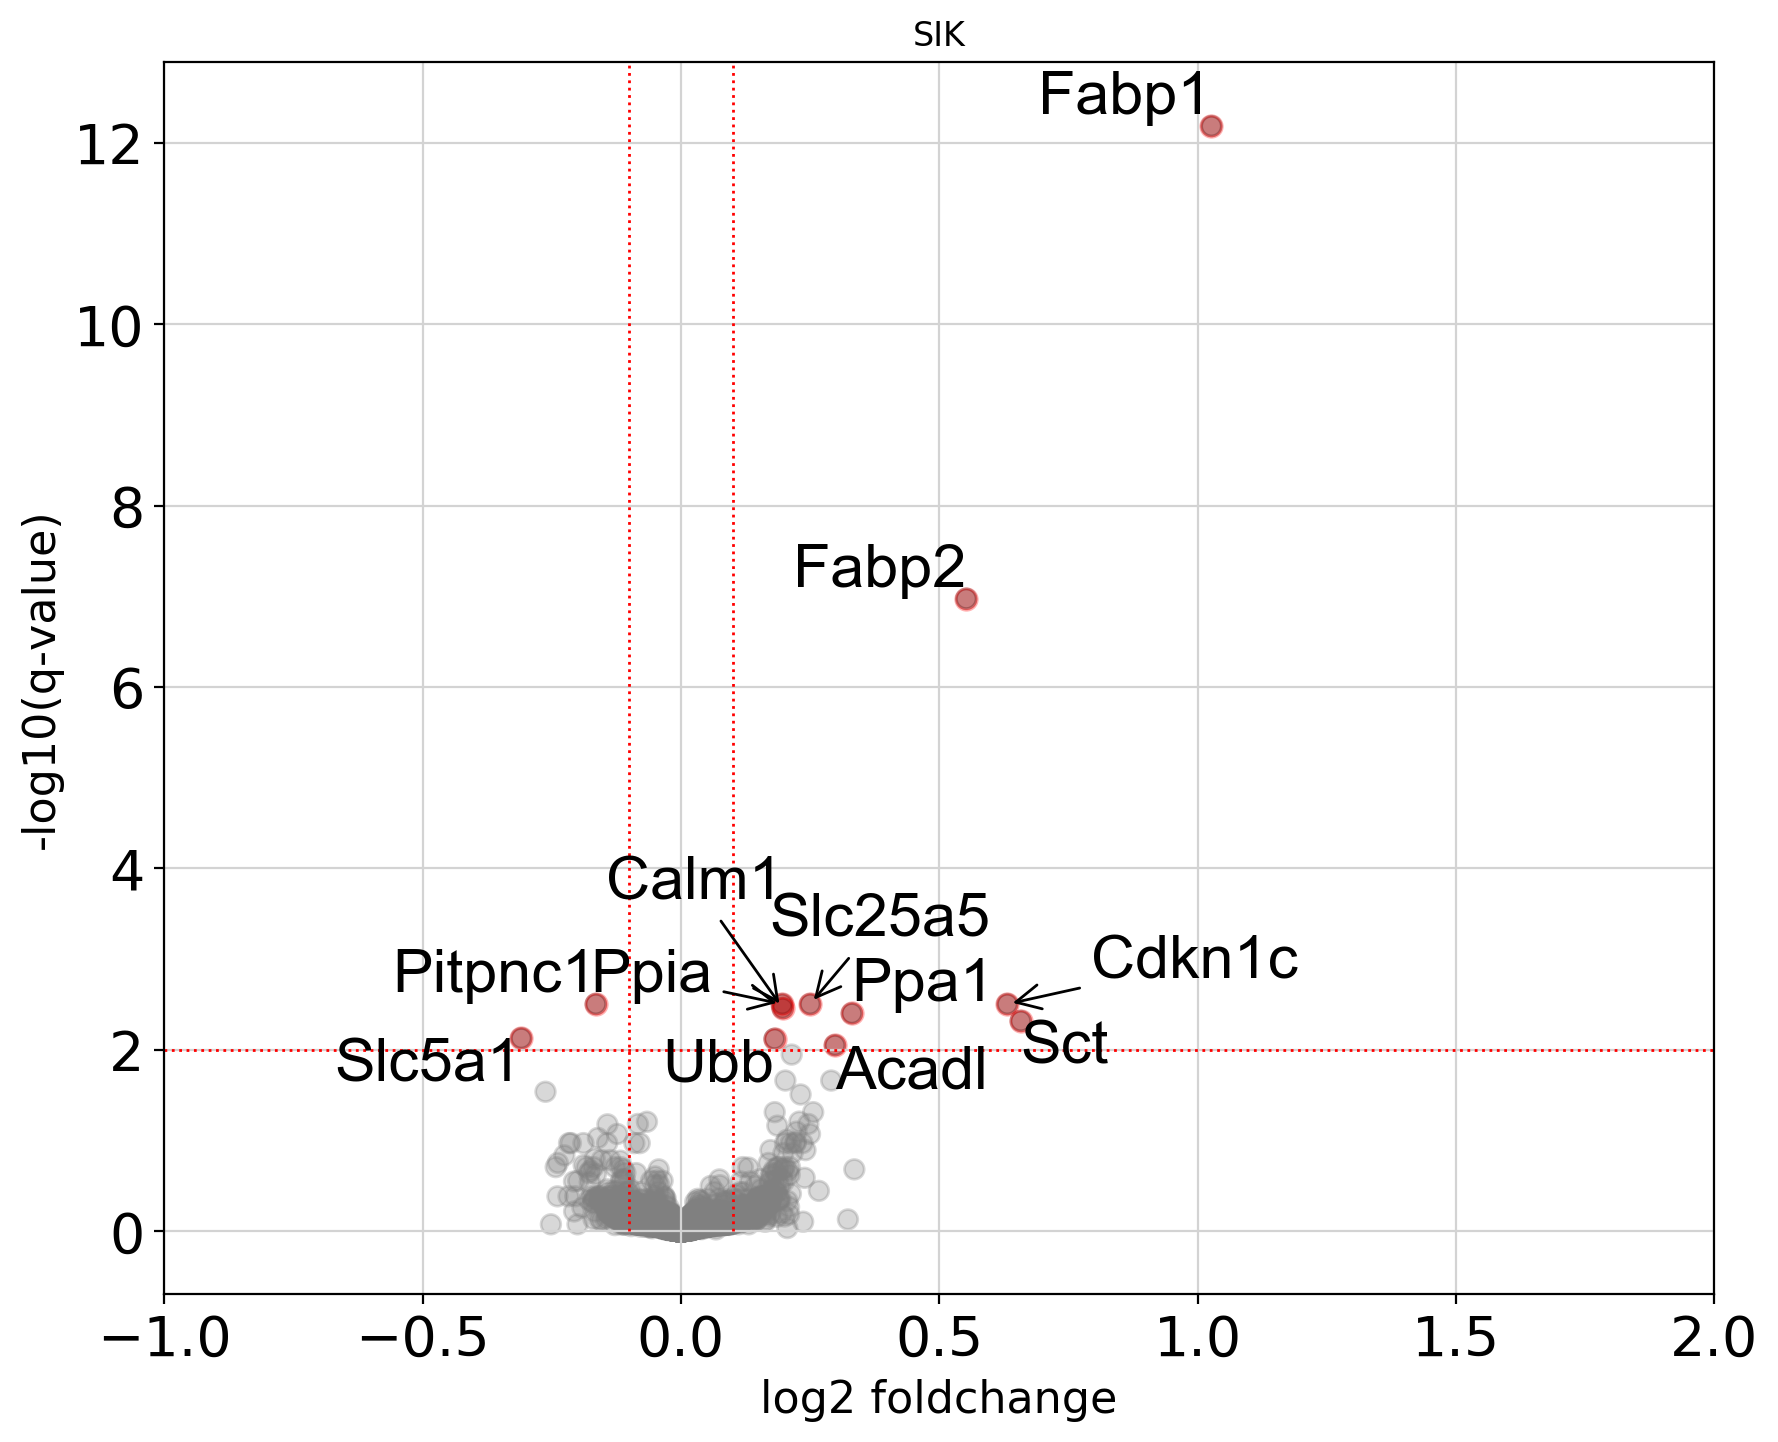

In [54]:
rcParams['figure.figsize'] = (10,8)

# volcano plot
ax, data_up, data_down = plot_volcano_top10(df1, x, y, 0.1, 2, data_point_size=50, xax=[-1, 2], yax=None)

# manually adapt label positions
for label, xa, ya in zip(data_down.index,data_down[x], data_down[y]):        
    if (label=='Pigr')| (label=='Oat'):
        ax.annotate(label,xy=(xa, ya), xytext=(-0.1, 0.1),textcoords='offset points', ha='left', va='top',fontsize=22,fontname='Arial')
    elif (label=='Khk')  | (label=='Slc5a1'):
        ax.annotate(label,xy=(xa, ya), xytext=(-0.1, 0.1),textcoords='offset points', ha='right', va='top',fontsize=22,fontname='Arial') 
    elif (label=='Atp1b1'):
        ax.annotate(label,xy=(xa, ya), xytext=(-0.1, 0.1),textcoords='offset points', ha='left', va='bottom',fontsize=22,fontname='Arial')   
    else:
        ax.annotate(label,xy=(xa, ya), xytext=(-0.1, 0.1),textcoords='offset points', ha='right', va='bottom',fontsize=22,fontname='Arial')
    
    
    
for label, xa, ya in zip(data_up.index,data_up[x], data_up[y]):        
    if (label=='Sct')|(label=='Acadl')|(label=='Acot1'):
        ax.annotate(label,xy=(xa, ya), xytext=(-0.1, 0.1),textcoords='offset points', ha='left', va='top',fontsize=22,fontname='Arial')
    elif (label=='Sct')|(label=='Ubb'):
        ax.annotate(label,xy=(xa, ya), xytext=(-0.1, 0.1),textcoords='offset points', ha='right', va='top',fontsize=22,fontname='Arial')
    elif (label=='Ppa1') :
        ax.annotate(label,xy=(xa, ya), xytext=(-0.1, 0.1),textcoords='offset points', ha='left', va='bottom',fontsize=22,fontname='Arial')  
    elif (label=='Calm1')  :
        ax.annotate(label,xy=(xa, ya), xytext=(0, 35),textcoords='offset points', 
                    ha='right', va='bottom',fontsize=22,fontname='Arial',arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
    elif (label=='Ppia')  :
        ax.annotate(label,xy=(xa, ya), xytext=(-25,0),textcoords='offset points', 
                    ha='right', va='bottom',fontsize=22,fontname='Arial',arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
    elif (label=='Slc25a5')  :
        ax.annotate(label,xy=(xa, ya), xytext=(65, 20),textcoords='offset points', 
                    ha='right', va='bottom',fontsize=22,fontname='Arial',arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
    elif (label=='Cdkn1c') :
        ax.annotate(label,xy=(xa, ya), xytext=(30, 5),textcoords='offset points', 
                    ha='left', va='bottom',fontsize=22,fontname='Arial',arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
    else:
        ax.annotate(label,xy=(xa, ya), xytext=(-0.1, 0.1),textcoords='offset points', ha='right', va='bottom',fontsize=22,fontname='Arial')#  

pl.title(group)
pl.setp(ax.get_xticklabels(), fontsize=20)
pl.setp(ax.get_yticklabels(), fontsize=20)
pl.grid(which='major',color='lightgrey')

pl.savefig('./figures/3_Volcano_SIK.pdf', dpi=300, format='pdf')
pl.show()

#### EC

In [55]:
genes_ambient= [
    'Defa24', 'Gm15284', 'Lyz1', 'Gm14851', 'Itln1', 'Defa17',
    'AY761184', 'Gm14850', 'Defa20', 'Clps', 'Gm7861', 'Spink4',
    'Ang4', 'Defa22', 'Defa26', 'Defa21', 'Fabp2', 'Gm21002', 'Defa23',
    'Defa-rs1', 'Gm15308', 'Defa3', 'Zg16', 'Agr2', 'Tff3', 'Reg4',
    'Ccl6', 'Defa5', 'Mptx2', 'Fcgbp', 'Tmsb10','Ifitm3', 'H2afv', 
    'Zfos1', 'Smim24', 'Plac8', 'Oat', 'Fth1', 'Aldob', 'Fabp1'
]

In [56]:
### prepare data
group = 'EC'

# transform p-values
df1 = pd.read_excel(filename, sheet_name = group, index_col=0)
df1['log_p'] = np.log10(df1['adj.P.Val'].values)
df1['log_p'][np.isneginf(df1['log_p'])] = min(df1['log_p'][np.invert(np.isneginf(df1['log_p']))])-1
df1['log_p'] = abs(df1['log_p'])

# exclude ambient genes
ix = np.isin(df1.index,genes_ambient)
df1 = df1[np.invert(ix)]

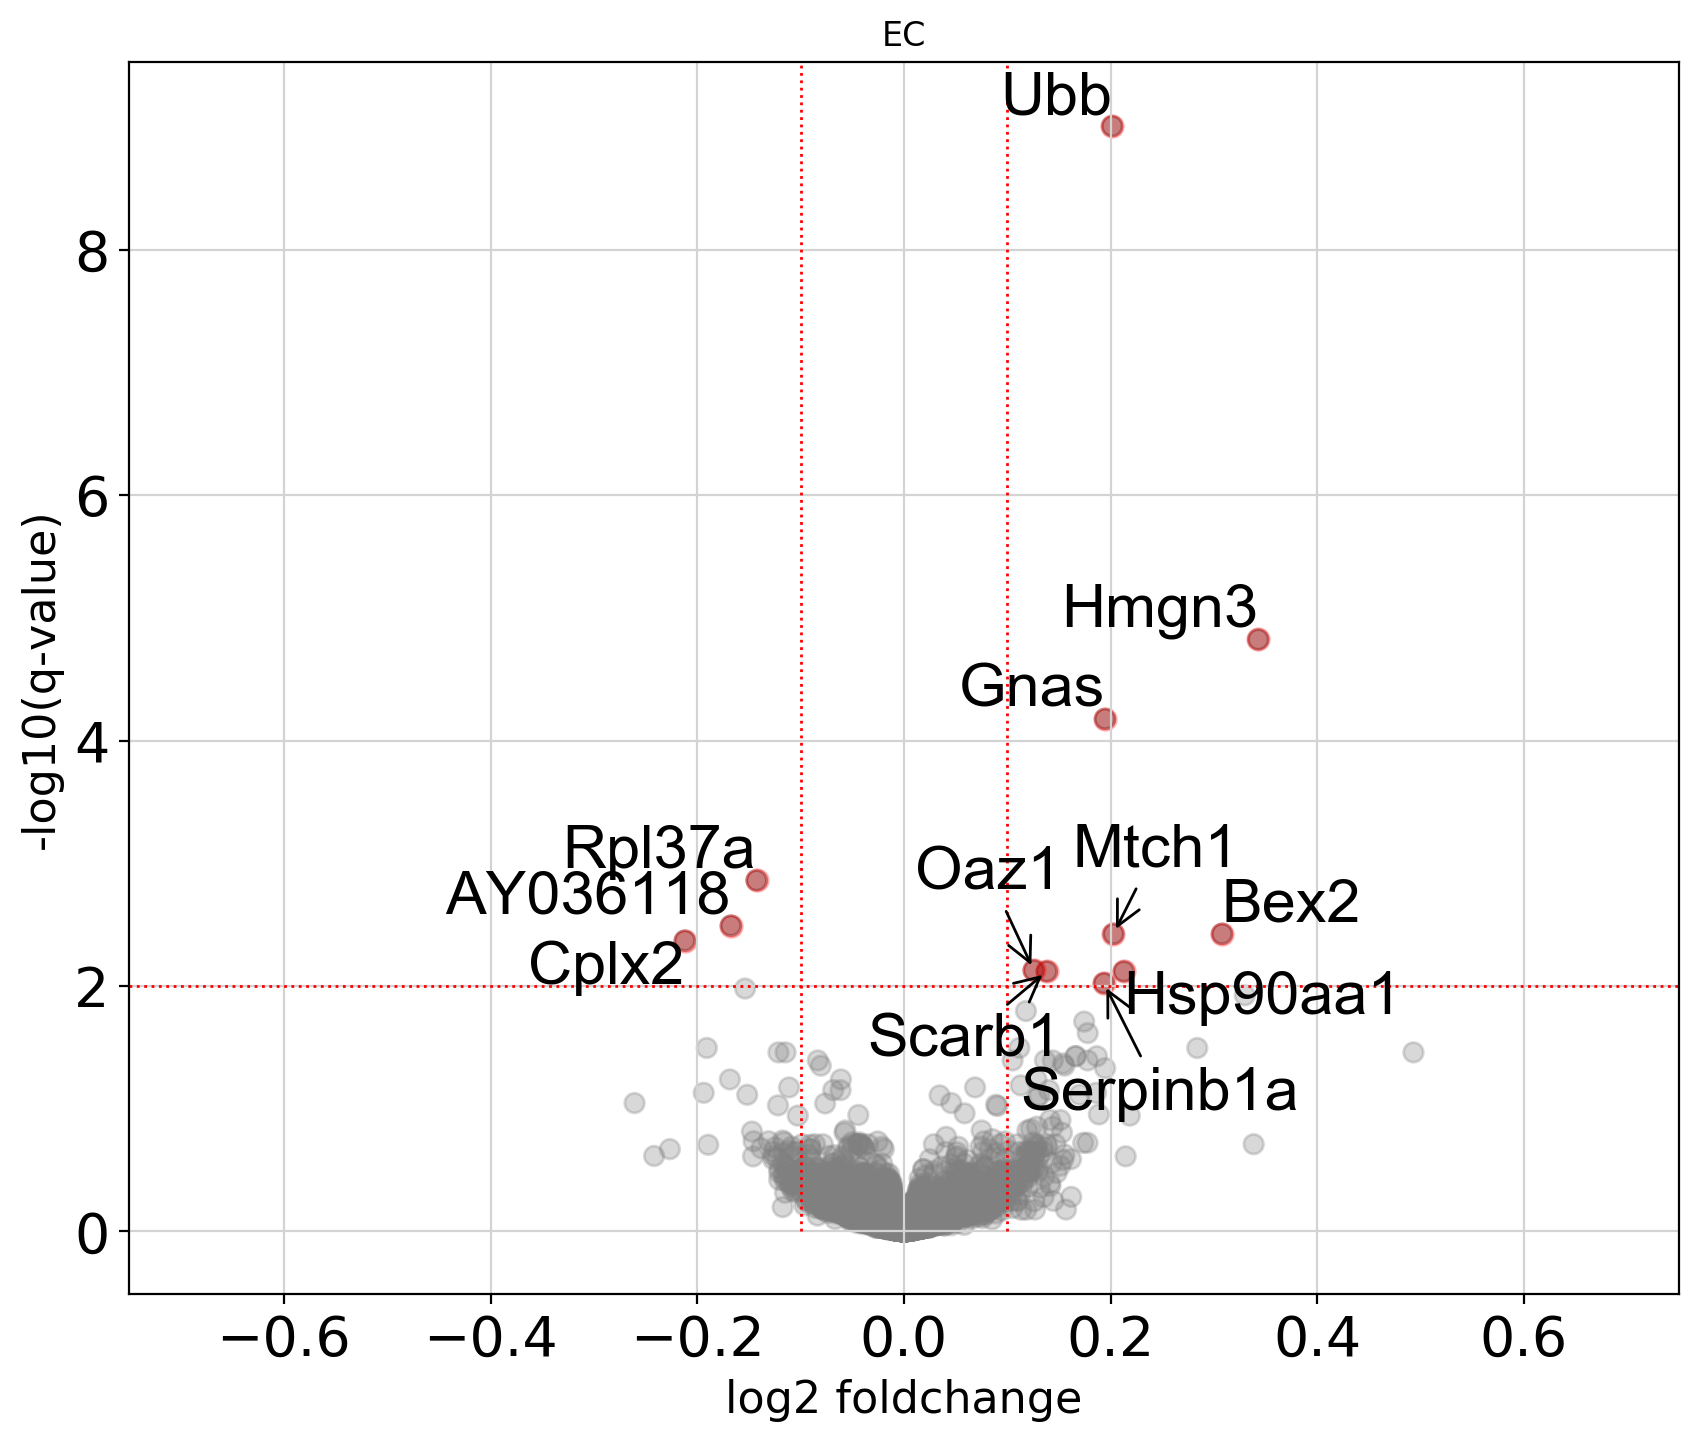

In [57]:
rcParams['figure.figsize'] = (10,8)

# volcano plot
ax, data_up, data_down = plot_volcano_top10(df1, x, y, 0.1, 2, data_point_size=50, xax=[-0.75,0.75], yax=None)

# manually adapt label positions
for label, xa, ya in zip(data_down.index,data_down[x], data_down[y]):        
    if (label=='Pigr')| (label=='Oat'):
        ax.annotate(label,xy=(xa, ya), xytext=(-0.1, 0.1),textcoords='offset points', ha='left', va='top',fontsize=22,fontname='Arial')
    elif (label=='Cplx2')  | (label=='Slc5a1'):
        ax.annotate(label,xy=(xa, ya), xytext=(-0.1, 0.1),textcoords='offset points', ha='right', va='top',fontsize=22,fontname='Arial') 
    elif (label=='Atp1b1'):
        ax.annotate(label,xy=(xa, ya), xytext=(-0.1, 0.1),textcoords='offset points', ha='left', va='bottom',fontsize=22,fontname='Arial')
    else:
        ax.annotate(label,xy=(xa, ya), xytext=(-0.1, 0.1),textcoords='offset points', ha='right', va='bottom',fontsize=22,fontname='Arial')
    
    
for label, xa, ya in zip(data_up.index,data_up[x], data_up[y]):        
    if (label=='Hsp90aa1'):
        ax.annotate(label,xy=(xa, ya), xytext=(-0.1, 0.1),textcoords='offset points', ha='left', va='top',fontsize=22,fontname='Arial')
    elif (label=='Hmgcs2')|(label=='Cyp4a10'):
        ax.annotate(label,xy=(xa, ya), xytext=(-0.1, 0.1),textcoords='offset points', ha='right', va='top',fontsize=22,fontname='Arial')   
    elif (label=='Bex2') :
        ax.annotate(label,xy=(xa, ya), xytext=(-0.1, 0.1),textcoords='offset points', ha='left', va='bottom',fontsize=22,fontname='Arial')  
    elif (label=='Mtch1') :
        ax.annotate(label,xy=(xa, ya), xytext=(45, 20),textcoords='offset points', 
                    ha='right', va='bottom',arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'),fontsize=22,fontname='Arial')
    elif (label=='Oaz1') :
        ax.annotate(label,xy=(xa, ya), xytext=(10, 25),textcoords='offset points', 
                    ha='right', va='bottom',arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0') ,fontsize=22,fontname='Arial')
    elif (label=='Serpinb1a') :
        ax.annotate(label,xy=(xa, ya), xytext=(-30, -50),textcoords='offset points', 
                    ha='left', va='bottom',arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0') ,fontsize=22,fontname='Arial')
    elif (label=='Scarb1') :
        ax.annotate(label,xy=(xa, ya), xytext=(5, -35),textcoords='offset points', 
                    ha='right', va='bottom',arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0') ,fontsize=22,fontname='Arial')
    else:
        ax.annotate(label,xy=(xa, ya), xytext=(-0.1, 0.1),textcoords='offset points', ha='right', va='bottom',fontsize=22,fontname='Arial')

pl.title(group)
pl.setp(ax.get_xticklabels(), fontsize=20)
pl.setp(ax.get_yticklabels(), fontsize=20)
pl.grid(which='major',color='lightgrey')

pl.savefig('./figures/3_Volcano_EC.pdf', dpi=300, format='pdf')
pl.show()

#### Ngn3+ progenitor

In [58]:
genes_ambient= [
    'Defa24', 'Gm15284', 'Lyz1', 'Gm14851', 'Itln1', 'Defa17',
    'AY761184', 'Gm14850', 'Defa20', 'Clps', 'Gm7861', 'Spink4',
    'Ang4', 'Defa22', 'Defa26', 'Defa21', 'Fabp2', 'Gm21002', 'Defa23',
    'Defa-rs1', 'Gm15308', 'Defa3', 'Zg16', 'Agr2', 'Tff3', 'Reg4',
    'Ccl6', 'Defa5', 'Mptx2', 'Fcgbp', 'Tmsb10','Ifitm3', 'H2afv', 
    'Zfos1', 'Smim24', 'Plac8', 'Oat', 'Fth1', 'Aldob'
]

In [59]:
### prepare data
group = 'Ngn3+ progenitor'

# transform p-values
df1 = pd.read_excel(filename, sheet_name = group, index_col=0)
df1['log_p'] = np.log10(df1['adj.P.Val'].values)
df1['log_p'][np.isneginf(df1['log_p'])] = min(df1['log_p'][np.invert(np.isneginf(df1['log_p']))])-1
df1['log_p'] = abs(df1['log_p'])

# exclude ambient genes
ix = np.isin(df1.index,genes_ambient)
df1 = df1[np.invert(ix)]

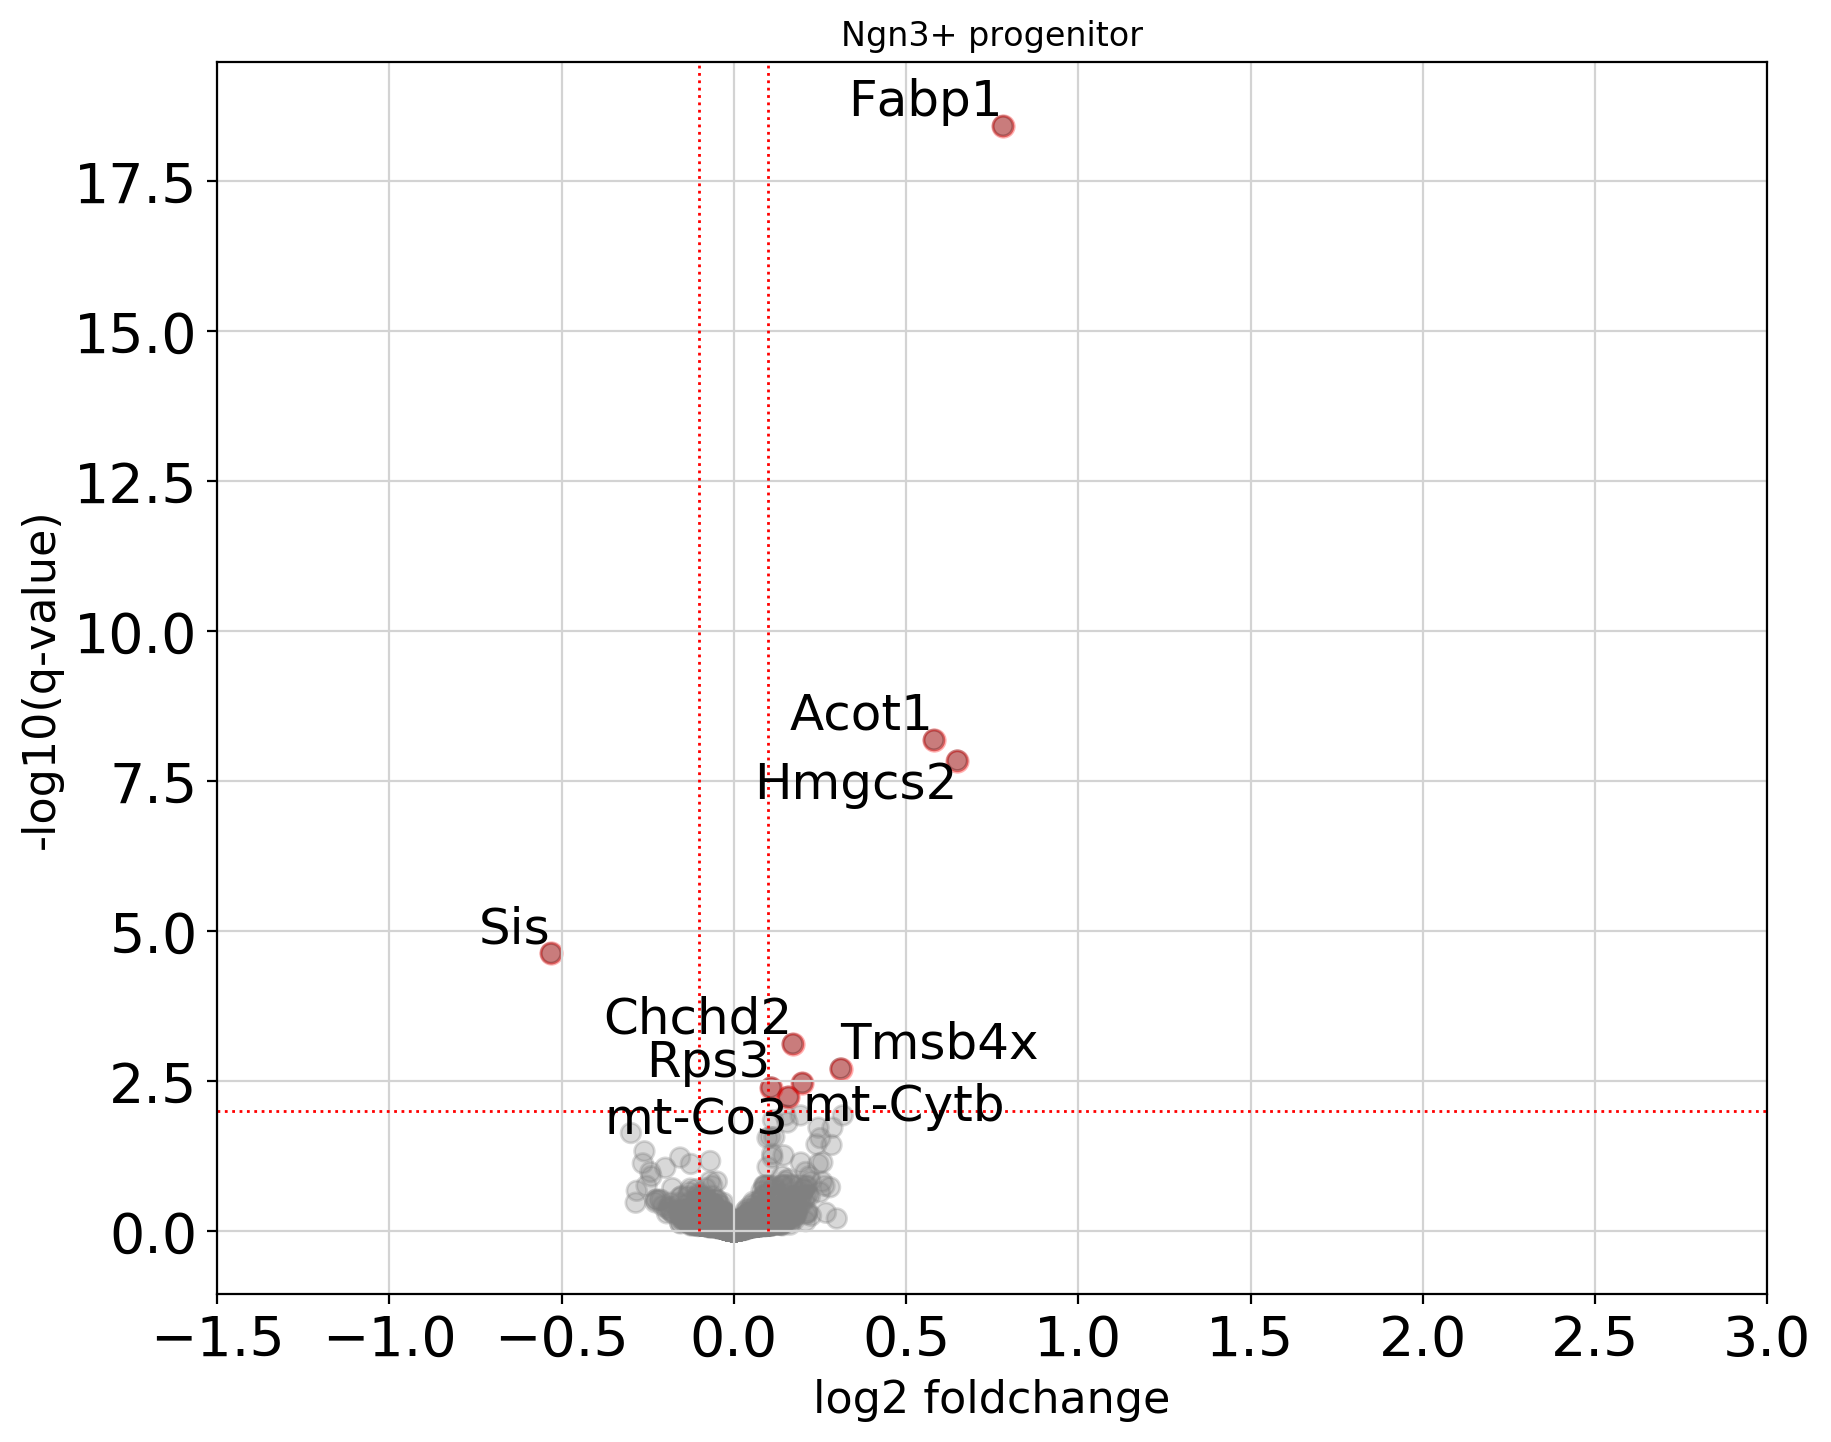

In [60]:
rcParams['figure.figsize'] = (10,8)

# volcano plot
ax, data_up, data_down = plot_volcano_top10(df1, x, y, 0.1, 2, data_point_size=50, xax=[-1.5,3], yax=None)

# manually adapt label positions
for label, xa, ya in zip(data_down.index,data_down[x], data_down[y]):        
    if (label=='Pigr')| (label=='Oat'):
        ax.annotate(label,xy=(xa, ya), xytext=(-0.1, 0.1),textcoords='offset points', ha='left', va='top',fontsize=18)
    elif (label=='Cplx2')  | (label=='Slc5a1'):
        ax.annotate(label,xy=(xa, ya), xytext=(-0.1, 0.1),textcoords='offset points', ha='right', va='top',fontsize=18)  
    elif (label=='Atp1b1'):
        ax.annotate(label,xy=(xa, ya), xytext=(-0.1, 0.1),textcoords='offset points', ha='left', va='bottom',fontsize=18) 
    else:
        ax.annotate(label,xy=(xa, ya), xytext=(-0.1, 0.1),textcoords='offset points', ha='right', va='bottom',fontsize=18)
    
    
    
for label, xa, ya in zip(data_up.index,data_up[x], data_up[y]):        
    if (label=='mt-Cytb'):
        ax.annotate(label,xy=(xa, ya), xytext=(-0.1, 0.1),textcoords='offset points', ha='left', va='top',fontsize=18)
    elif (label=='mt-Co3')|(label=='Hmgcs2'):
        ax.annotate(label,xy=(xa, ya), xytext=(-0.1, 0.1),textcoords='offset points', ha='right', va='top',fontsize=18)
    elif (label=='Fabp2')|(label=='Tmsb4x') :
        ax.annotate(label,xy=(xa, ya), xytext=(-0.1, 0.1),textcoords='offset points', ha='left', va='bottom',fontsize=18)
    else:
        ax.annotate(label,xy=(xa, ya), xytext=(-0.1, 0.1),textcoords='offset points', ha='right', va='bottom',fontsize=18)

pl.title(group)
pl.setp(ax.get_xticklabels(), fontsize=20)
pl.setp(ax.get_yticklabels(), fontsize=20)
pl.grid(which='major',color='lightgrey')

pl.savefig('./figures/3_Volcano_Ngn3.pdf', dpi=300, format='pdf')
pl.show()

#### Sox4+ early EE progenitor

In [64]:
genes_ambient= [
    'Defa24', 'Gm15284', 'Lyz1', 'Gm14851', 'Itln1', 'Defa17',
    'AY761184', 'Gm14850', 'Defa20', 'Clps', 'Gm7861', 'Spink4',
    'Ang4', 'Defa22', 'Defa26', 'Defa21', 'Gm21002', 'Defa23',
    'Defa-rs1', 'Gm15308', 'Defa3', 'Zg16', 'Agr2', 'Tff3', 'Reg4',
    'Ccl6', 'Defa5', 'Mptx2', 'Fcgbp', 'Tmsb10','Ifitm3', 'H2afv', 
    'Zfos1', 'Smim24', 'Plac8', 'Oat', 'Fth1', 'Aldob'
]
# Fabp1 and Fabp2: above ambient differences

In [65]:
### prepare data
group = 'Sox4+ early EE progenitor'

# transform p-values
df1 = pd.read_excel(filename, sheet_name = group, index_col=0)
df1['log_p'] = np.log10(df1['adj.P.Val'].values)
df1['log_p'][np.isneginf(df1['log_p'])] = min(df1['log_p'][np.invert(np.isneginf(df1['log_p']))])-1
df1['log_p'] = abs(df1['log_p'])

# exclude ambient genes
ix = np.isin(df1.index,genes_ambient)
df1 = df1[np.invert(ix)]

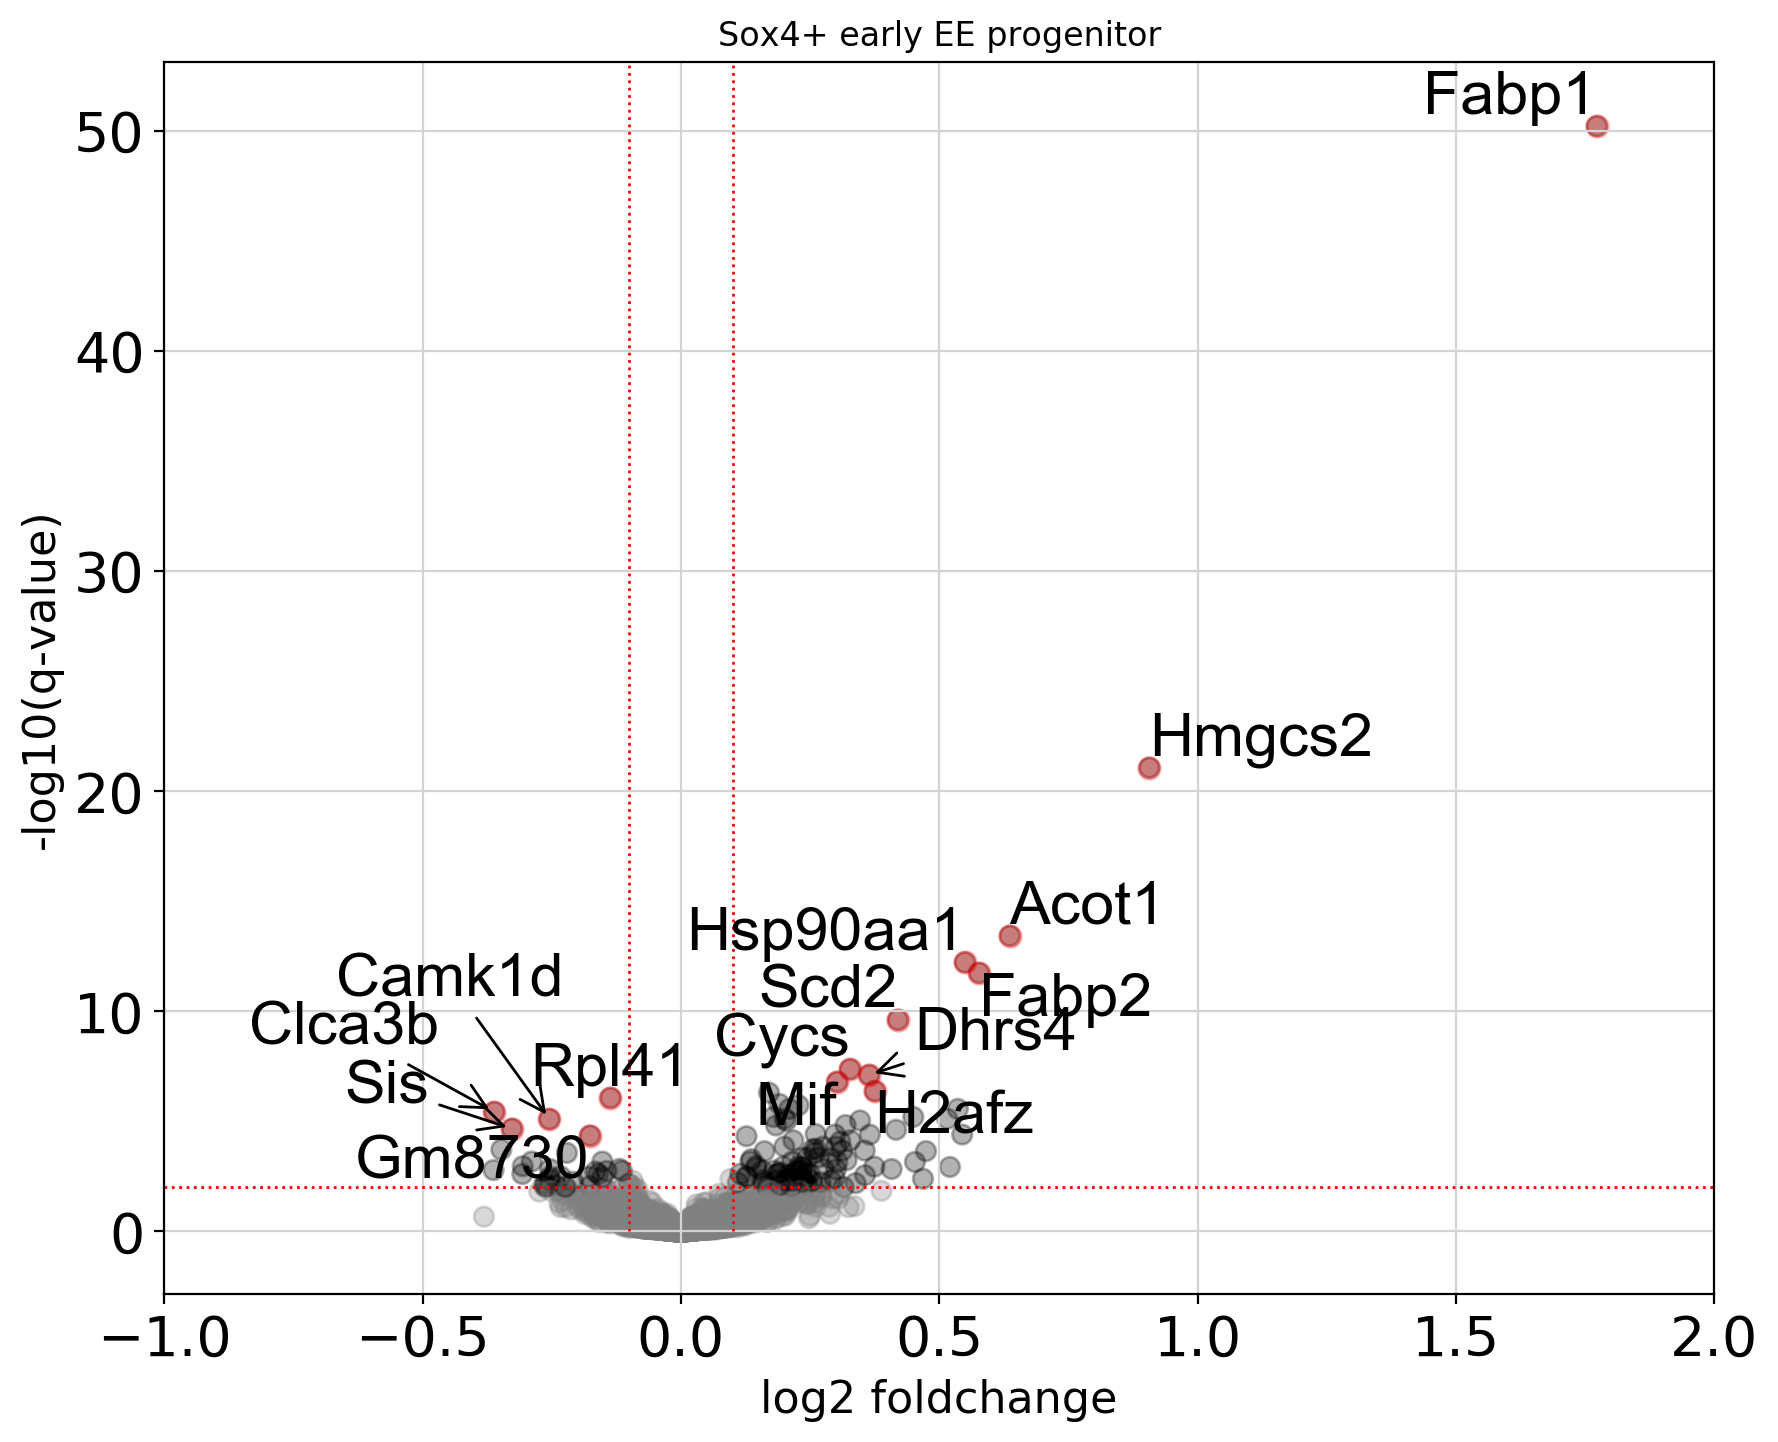

In [67]:
rcParams['figure.figsize'] = (10,8)

# volcano plot
ax, data_up, data_down = plot_volcano_top10(df1, x, y, 0.1, 2, data_point_size=50, xax=[-1,2], yax=None)

# manually adapt label positions
for label, xa, ya in zip(data_down.index,data_down[x], data_down[y]):        
    if (label=='Gm8730')| (label=='Oat'):
        ax.annotate(label,xy=(xa, ya), xytext=(-0.1, 0.1),textcoords='offset points', ha='right', va='top',fontsize=22,fontname='Arial')
    elif (label=='Cplx2')  | (label=='Slc5a1'):
        ax.annotate(label,xy=(xa, ya), xytext=(-0.1, 0.1),textcoords='offset points', ha='right', va='top',fontsize=22,fontname='Arial') 
    elif (label=='Rpl41'):
        ax.annotate(label,xy=(xa, ya), xytext=(-0.1, 0.1),textcoords='offset points', ha='center', va='bottom',fontsize=22,fontname='Arial')
    elif (label=='Camk1d')  :
        ax.annotate(label,xy=(xa, ya), xytext=(5, 40),textcoords='offset points', 
                    ha='right', va='bottom',arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0') ,fontsize=22,fontname='Arial')
    elif (label=='Sis')  :
        ax.annotate(label,xy=(xa, ya), xytext=(-30, 5),textcoords='offset points', 
                    ha='right', va='bottom',arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0') ,fontsize=22,fontname='Arial')
    elif (label=='Clca3b')  :
        ax.annotate(label,xy=(xa, ya), xytext=(-20, 20),textcoords='offset points', 
                    ha='right', va='bottom',arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0') ,fontsize=22,fontname='Arial')
    else:
        ax.annotate(label,xy=(xa, ya), xytext=(-0.1, 0.1),textcoords='offset points', ha='right', va='bottom',fontsize=22,fontname='Arial')
    
    
for label, xa, ya in zip(data_up.index,data_up[x], data_up[y]):        
    if (label=='Fabp2')|(label=='H2afz'):
        ax.annotate(label,xy=(xa, ya), xytext=(-0.1, 0.1),textcoords='offset points', ha='left', va='top',fontsize=22,fontname='Arial')
    elif (label=='Mif'):
        ax.annotate(label,xy=(xa, ya), xytext=(-0.1, 0.1),textcoords='offset points', ha='right', va='top',fontsize=22,fontname='Arial')
    elif (label=='Acot1')|(label=='Tmsb4x')|(label=='Hmgcs2') :
        ax.annotate(label,xy=(xa, ya), xytext=(-0.1, 0.1),textcoords='offset points', ha='left', va='bottom',fontsize=22,fontname='Arial')
    elif (label=='Dhrs4')  :
        ax.annotate(label,xy=(xa, ya), xytext=(75, 5),textcoords='offset points', 
                    ha='right', va='bottom',arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'),fontsize=22,fontname='Arial')
    else:
        ax.annotate(label,xy=(xa, ya), xytext=(-0.1, 0.1),textcoords='offset points', ha='right', va='bottom',fontsize=22,fontname='Arial')

pl.title(group)
pl.setp(ax.get_xticklabels(), fontsize=20)
pl.setp(ax.get_yticklabels(), fontsize=20)
pl.grid(which='major',color='lightgrey')

pl.savefig('./figures/3_Volcano_Sox4.pdf', dpi=300, format='pdf')
pl.show()

## BMP signaling

BMP signaling from GO

In [68]:
# %%time
# from intermine.webservice import Service
# service = Service("http://www.mousemine.org/mousemine/service")
# query = service.new_query("SequenceFeature")
# query.add_constraint("ontologyAnnotations.ontologyTerm", "GOTerm")
# query.add_view("ontologyAnnotations.ontologyTerm.name", "primaryIdentifier", "symbol")
# query.add_constraint("ontologyAnnotations.dataSets.name", "=", "GOTerm to Mouse Feature Annotations from MGI", code = "A")
# query.add_constraint("organism.taxonId", "=", "10090", code = "D")
# query.add_constraint("ontologyAnnotations.ontologyTerm", "LOOKUP", "GO:0030509", code = "C")
# genes=list()
# for row in query.rows():
#    genes.append(row["symbol"])


# genes_bmp_go = [gene for gene in genes if gene in adata_all.var_names]

CPU times: user 175 ms, sys: 10.6 ms, total: 186 ms
Wall time: 3.78 s


BMP signaling from KEGG

In [70]:
# %%time
# from bioservices.kegg import KEGG
# k = KEGG()
# k.organism = 'mmu'

CPU times: user 430 ms, sys: 91.1 ms, total: 522 ms
Wall time: 27.4 s


In [71]:
# data = k.get("mmu04350")
# dict_data = k.parse(data)
# x = dict_data['GENE']
# y=pd.DataFrame.from_dict(x, orient='index')
# y=y[0].str.split(pat=';', n=0, expand=True)

# genes_bmp_kegg=[gene for gene in list(y[0]) if gene in adata_all.var_names]

In [72]:
# genes_bmp = set(genes_bmp_go).union(genes_bmp_kegg)

In [87]:
genes_bmp = ['Acvr1', 'Acvr1b', 'Acvr1c', 'Acvr2a', 'Acvr2b', 'Acvrl1', 'Amh', 'Amhr2', 'Bambi', 'Bmp2', 'Bmp3', 'Bmp7', 'Bmp8a', 'Bmp8b', 'Bmpr1a', 'Bmpr2', 
             'Cdkn2b', 'Comp', 'Crebbp', 'Cul1', 'Ddx5', 'E2f4', 'E2f5', 'Ecsit', 'Egr1', 'Ep300', 'Fam83g', 'Fst', 'Gdf15', 'Gdf9', 'Hamp2', 'Hfe', 'Hivep1',
             'Id1', 'Id2', 'Id3', 'Id4', 'Ifng', 'Inhbb', 'Inhbc', 'Lef1', 'Lefty1', 'Mapk1', 'Mapk3', 'Megf8', 'Msx1', 'Myc', 'Neo1', 'Pdcd4', 'Pitx2', 'Ppp2ca',
             'Ppp2cb', 'Ppp2r1a', 'Ppp2r1b', 'Rbl1', 'Rbx1', 'Rgma', 'Rgmb', 'Rhoa', 'Rock1', 'Ror2', 'Rps6kb1', 'Rps6kb2', 'Runx2', 'Scx', 'Skp1a', 'Slc33a1',
             'Slc39a5', 'Smad1', 'Smad2', 'Smad3', 'Smad4', 'Smad5', 'Smad9', 'Smpd3', 'Sp1', 'Tfdp1', 'Tgfb1', 'Tgfb2', 'Tgfb3', 'Tgfbr1', 'Tgfbr2', 'Tgfbr3',
             'Tgif1', 'Tgif2', 'Thbs1', 'Thsd4', 'Tnf', 'Usp15', 'Usp9x', 'Vsir', 'Zcchc12', 'Zcchc18', 'Zfp128', 'Zfyve16', 'Zfyve9', 'Nbl1', 'Hipk2', 'Tob1', 
             'Fzd1', 'Fstl3', 'Ski']

In [88]:
# filter low expressed genes
sc.pp.filter_genes(adata_eec, min_cells=30)

In [89]:
genes = [gene for gene in genes_bmp if gene in adata_eec.var_names]
adata_sub = adata_eec[:, genes].copy()

df = pd.DataFrame(adata_sub.X.toarray(), columns=adata_sub.var_names)
df['groups_named_eec_final'] = adata_sub.obs.groups_named_eec_final.values

In [90]:
df_mean = df.groupby('groups_named_eec_final').mean()

Text(0.5, 99.38005886681385, '')

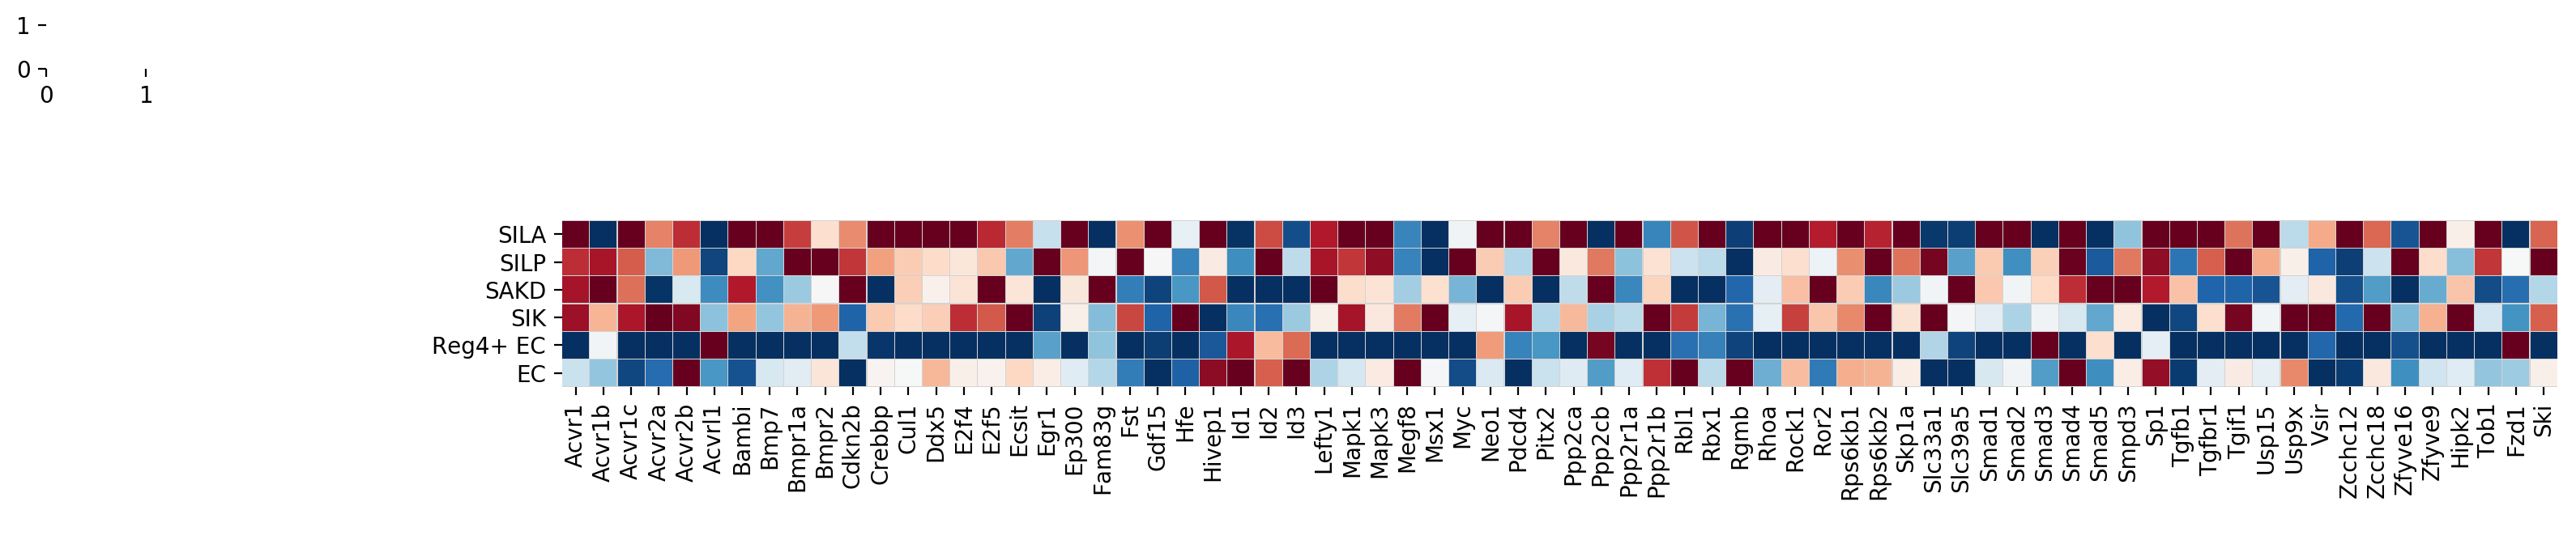

In [91]:
ax = sns.clustermap(df_mean[genes], cmap='RdBu_r', cbar=None, standard_scale=1, row_cluster=False, col_cluster=False, square=True,
                    figsize=(20,4), yticklabels=1, xticklabels=1, linewidths=0.05, linecolor='lightgrey');
ax.ax_heatmap.set_yticklabels(ax.ax_heatmap.get_yticklabels());
ax.ax_heatmap.yaxis.tick_left();
ax.ax_heatmap.set_ylabel('')
ax.ax_heatmap.set_xlabel('')